In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def prepare_vol(rolling_window=22, 
                prediction_window=22, 
                seq_len = 30,
                subsample=True,
                index='KOSPI2 Index'):
    price_data = pd.read_excel('price_data.xlsx', index_col=0).iloc[1:, :]
    price_data.index = pd.to_datetime(price_data.index)

    if subsample:
        price_data = price_data.loc['2001-01-01':'2017-01-01', :]


    KOSPI = price_data[[index]].dropna().copy()
    KOSPI['LOG_PRICE'] = np.log(KOSPI[index].astype(float))
    KOSPI['RETURN'] = KOSPI['LOG_PRICE'].diff()

    KOSPI = KOSPI.dropna()
    KOSPI_STD = KOSPI.rolling(window=rolling_window).std()

    data_set = pd.DataFrame({'VOL': KOSPI_STD['RETURN']})

    data_set['VOL+'+str(prediction_window)] = KOSPI_STD['RETURN'].shift(-prediction_window)

    data_set = data_set.dropna()
    return data_set


def prepare_explanary(subsample=True, index = 'KOSPI2 Index'):
    '''
    get explanary variables(all X except vol)
    '''    
    if index == 'SPX Index':
        country = 'us'
    elif index == 'KOSPI2 Index':
        country = 'korea'
    else:
        print('Wrong index!')
        exit()
    ytm_data = pd.read_excel('bond_ytm.xlsx', index_col=0).iloc[1:, :]
    ytm_data.index = pd.to_datetime(ytm_data.index)
    ytm_data = ytm_data[[country+' corp bond ytm', country+' gov bond ytm']]
    price_data = pd.read_excel('price_data.xlsx', index_col=0).iloc[1:, :]
    price_data.index = pd.to_datetime(price_data.index)
    price_data = price_data[['XAU Curncy', 'USCRWTIC Index']]

    exp_data = pd.merge(ytm_data, price_data, left_index=True, right_index=True)

    if country == 'korea':
        file_name = 'kospi'
    elif country == 'us':
        file_name = 'spx'
    params_data = pd.read_csv(''+file_name+'_garch_variables_2000.csv', index_col=0)
    params_data.index = pd.to_datetime(params_data.index)
    exp_data = pd.merge(exp_data, params_data, left_index=True, right_index=True)

    if subsample:
        exp_data = exp_data.loc['2001-01-01':'2017-01-01', :]
    return exp_data

def prepare_data(exp_variables,
    rolling_window=22,
    prediction_window=22,
    seq_len = 30,
    subsample=False,
    split_point=0.66,
    index='KOSPI2 Index'):

    vol = prepare_vol(rolling_window, prediction_window, seq_len, subsample, index)
    exp_data = prepare_explanary(subsample, index)
    dataset = pd.merge(exp_data[exp_variables], vol, left_index=True, right_index=True, how='right')
    dataset = dataset.fillna(method='ffill')
    dataset = dataset.dropna()

    tmp_X = dataset.iloc[:, :-1]
    tmp_Y = dataset.iloc[:,[-1]]
    features = tmp_X.shape[1]
    li_X = []

    for i in range(seq_len):
        li_X.append(tmp_X.shift(i))
    li_X.append(tmp_Y)
    dataset_2 = pd.concat(li_X, axis=1)
    dataset_2 = dataset_2.dropna()

    X = dataset_2.iloc[:, :-1]
    Y = dataset_2.iloc[:,[-1]]
    li_X_2 = []
    for i in range(seq_len):
        tmp = torch.Tensor(X.iloc[:, features*i:features*(i+1)].values).view(1, -1, features)
        li_X_2.append(tmp)
    X = torch.cat(li_X_2, dim=0)
    Y = torch.Tensor(Y.values)
    Y = Y.T
    Y = Y.view((1, -1, 1))

    split = int(X.shape[1]*split_point)

    return {'train_set':[X[:, :split, :], Y[:, :split, :]], 
            'test_set':[X[:, split:, :], Y[:, split:, :]]}


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class StandardScaler():
    """Standardize data by removing the mean and scaling to
    unit variance.  This object can be used as a transforma
    in PyTorch data loaders.

    Args:
        mean (FloatTensor): The mean value for each feature in the data.
        scale (FloatTensor): Per-feature relative scaling.
    """

    def __init__(self, mean=None, scale=None):
        if mean is not None:
            mean = torch.FloatTensor(mean)
        if scale is not None:
            scale = torch.FloatTensor(scale)
        self.mean_ = mean
        self.scale_ = scale

    def fit(self, sample):
        """Set the mean and scale values based on the sample data.
        """
        self.mean_ = sample.mean(1, keepdim=True).to(device)
        self.scale_ = sample.std(1, unbiased=False, keepdim=True).to(device)
        return self

    def transform(self, sample):
        return (sample - self.mean_)/self.scale_

    def inverse_transform(self, sample):
        """Scale the data back to the original representation
        """
        return sample * self.scale_ + self.mean_

torch.manual_seed(1)


class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,layer_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.dropout = nn.Dropout(p=0.3)
        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, dropout=0.8)
        self.fc1 = nn.Linear(hidden_size, int(hidden_size/2))
        self.fc2 = nn.Linear(int(hidden_size/2), 1)
    
    def forward(self,voltility):
        voltility = self.dropout(voltility)
        lstm_out, _ = self.lstm(voltility)
        next_vol = self.fc1(lstm_out[[-1], :, :])
        next_vol = self.fc2(next_vol)
        return next_vol


def split_test(input_size,hidden_size,layer_size, exp_variables, index, split=0.628515):
    global plot
    model = LSTM(input_size,hidden_size,layer_size).to(device)
    loss_function = F.torch.nn.MSELoss()
    opt = optim.Adam(model.parameters(), lr=0.01)

    data_set = prepare_data(exp_variables, index=index, split_point = split)
    train_X, train_Y = data_set['train_set']
    test_X, test_Y = data_set['test_set']
    
    train_X = train_X.to(device)
    train_Y = train_Y.to(device)
    
    test_X = test_X.to(device)
    test_Y = test_Y.to(device)

    train_X_scaler =StandardScaler().fit(train_X)
    train_X = train_X_scaler.transform(train_X)
    train_Y_scaler = StandardScaler().fit(train_Y)
    train_Y = train_Y_scaler.transform(train_Y)

    test_X = train_X_scaler.transform(test_X)
    test_Y = train_Y_scaler.transform(test_Y)


    
    train_loss = []
    test_loss = []
    for epoch in range(2000):
        model.zero_grad()
        output = model(train_X)
        loss = loss_function(output, train_Y)
        loss.backward()
        opt.step()
        train_loss.append(loss.item())
        test_loss.append(loss_function(model(test_X), test_Y).item())

        if epoch%50 == 0 and plot:
            print("epoch: ", epoch, ', loss: ', loss.item())

    with torch.no_grad():
        OOS_Y = model(test_X).detach()
        output = output.detach()
        OOS_Y = train_Y_scaler.inverse_transform(OOS_Y).cpu().numpy().flat
        Test_Y = train_Y_scaler.inverse_transform(test_Y).cpu().numpy().flat
        
        Train_Y = train_Y_scaler.inverse_transform(train_Y).cpu().numpy().flat
        Train_ouput_Y = train_Y_scaler.inverse_transform(output).cpu().numpy().flat
        
        test_merged = pd.DataFrame({'RV':Test_Y, 'pre':OOS_Y})
        train_merged = pd.DataFrame({'RV':Train_Y, 'pre':Train_ouput_Y})
    
        test_MAE = np.abs(test_merged.iloc[:,0] - test_merged.iloc[:,1]).mean()
        train_MAE = np.abs(train_merged.iloc[:,0] - train_merged.iloc[:,1]).mean()
        total_MAE = (test_MAE * len(test_merged) + train_MAE * len(train_merged)) / (len(test_merged) + len(train_merged))
        MAE = [train_MAE*100, test_MAE*100, total_MAE*100]

        test_MSE = np.square(test_merged.iloc[:,0] - test_merged.iloc[:,1]).mean()
        train_MSE = np.square(train_merged.iloc[:,0] - train_merged.iloc[:,1]).mean()
        total_MSE = (test_MSE * len(test_merged) + train_MSE * len(train_merged)) / (len(test_merged) + len(train_merged))
        MSE = [train_MSE*10000, test_MSE*10000, total_MSE*10000]
        
        test_HMAE = np.abs(1 - test_merged.iloc[:,1] / test_merged.iloc[:,0]).mean()
        train_HMAE = np.abs(1 - train_merged.iloc[:,1] / train_merged.iloc[:,0]).mean()
        total_HMAE = (test_HMAE * len(test_merged) + train_HMAE * len(train_merged)) / (len(test_merged) + len(train_merged))
        HMAE = [train_HMAE, test_HMAE, total_HMAE]
    
        test_HMSE = np.square(1 - test_merged.iloc[:,1] / test_merged.iloc[:,0]).mean()
        train_HMSE = np.square(1 - train_merged.iloc[:,1] / train_merged.iloc[:,0]).mean()
        total_HMSE = (test_HMSE * len(test_merged) + train_HMSE * len(train_merged)) / (len(test_merged) + len(train_merged))
        HMSE = [train_HMSE, test_HMSE, total_HMSE]
        ret = pd.DataFrame({'MAE':MAE, 'MSE':MSE, 'HMAE':HMAE, 'HMSE':HMSE}, index=['Train', 'Test', 'Total'])
        
        fig, ax = plt.subplots(2, 2, figsize=(18, 12))
        ax[0][0].plot(train_Y_scaler.inverse_transform(train_Y).cpu().numpy().flat)
        ax[0][0].plot(train_Y_scaler.inverse_transform(model(train_X)).detach().cpu().numpy().flat)
        ax[0][0].legend(['true', 'predict'])
        ax[0][0].set_title('Train Set')

        ax[0][1].plot(Test_Y)
        ax[0][1].plot(OOS_Y)
        ax[0][1].legend(['true', 'predict'])
        ax[0][1].set_title('Test Set')

        ax[1][0].plot(train_loss)
        ax[1][0].set_title('Train Loss')

        ax[1][1].plot(test_loss)
        ax[1][1].set_title('Test Loss')

        plt.show()
        print(ret)
        
def rolling_test(input_size,hidden_size,layer_size, exp_variables, index, split=0.628515):
    global plot


    data_set = prepare_data(exp_variables, index=index, split_point = split)
    train_X, train_Y = data_set['train_set']
    test_X, test_Y = data_set['test_set']
    
    train_X = train_X.to(device)
    train_Y = train_Y.to(device)
    
    test_X = test_X.to(device)
    test_Y = test_Y.to(device)

    train_X_scaler =StandardScaler().fit(train_X)
    train_X = train_X_scaler.transform(train_X)
    train_Y_scaler = StandardScaler().fit(train_Y)
    train_Y = train_Y_scaler.transform(train_Y)

    test_X = train_X_scaler.transform(test_X)
    test_Y = train_Y_scaler.transform(test_Y)


    
    train_loss = []
    test_loss = []
    Test_Y = []
    OOS_Y = []
    Train_Y = []
    Train_output_Y = []
    for i in range(int(test_Y.shape[1]/22)):
        model = LSTM(input_size,hidden_size,layer_size).to(device)
        loss_function = F.torch.nn.MSELoss()
        opt = optim.Adam(model.parameters(), lr=0.01)
        model.train()
        this_train_X = torch.cat([train_X[:, i*22:, :], test_X[:, :i*22, :]], axis=1)
        this_train_Y = torch.cat([train_Y[:, i*22:, :], test_Y[:, :i*22, :]], axis=1)
        this_test_X = test_X[:, i*22:(i+1)*22, :]
        this_test_Y = test_Y[:, i*22:(i+1)*22, :]
        
        for epoch in range(1000):
            model.zero_grad()
            output = model(this_train_X)
            loss = loss_function(output, this_train_Y)
            loss.backward()
            opt.step()
                
        model.eval()
        
        with torch.no_grad():
            output = output.detach()
            OOS_Y.extend(train_Y_scaler.inverse_transform(model(this_test_X).detach()).cpu().numpy().reshape(-1).tolist())
            Test_Y.extend(train_Y_scaler.inverse_transform(this_test_Y).cpu().numpy().reshape(-1).tolist())

            Train_Y.extend(train_Y_scaler.inverse_transform(this_train_Y).cpu().numpy().reshape(-1).tolist())
            Train_output_Y.extend(train_Y_scaler.inverse_transform(output).cpu().numpy().reshape(-1).tolist())
        
    test_merged = pd.DataFrame({'RV':Test_Y, 'pre':OOS_Y})
    train_merged = pd.DataFrame({'RV':Train_Y, 'pre':Train_output_Y})
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(test_merged)
    ax.legend(['Realized Vol', 'Predicted Vol'])
    test_MAE = np.abs(test_merged.iloc[:,0] - test_merged.iloc[:,1]).mean()
    train_MAE = np.abs(train_merged.iloc[:,0] - train_merged.iloc[:,1]).mean()
    total_MAE = (test_MAE * len(test_merged) + train_MAE * len(train_merged)) / (len(test_merged) + len(train_merged))
    MAE = [train_MAE*100, test_MAE*100, total_MAE*100]

    test_MSE = np.square(test_merged.iloc[:,0] - test_merged.iloc[:,1]).mean()
    train_MSE = np.square(train_merged.iloc[:,0] - train_merged.iloc[:,1]).mean()
    total_MSE = (test_MSE * len(test_merged) + train_MSE * len(train_merged)) / (len(test_merged) + len(train_merged))
    MSE = [train_MSE*10000, test_MSE*10000, total_MSE*10000]

    test_HMAE = np.abs(1 - test_merged.iloc[:,1] / test_merged.iloc[:,0]).mean()
    train_HMAE = np.abs(1 - train_merged.iloc[:,1] / train_merged.iloc[:,0]).mean()
    total_HMAE = (test_HMAE * len(test_merged) + train_HMAE * len(train_merged)) / (len(test_merged) + len(train_merged))
    HMAE = [train_HMAE, test_HMAE, total_HMAE]

    test_HMSE = np.square(1 - test_merged.iloc[:,1] / test_merged.iloc[:,0]).mean()
    train_HMSE = np.square(1 - train_merged.iloc[:,1] / train_merged.iloc[:,0]).mean()
    total_HMSE = (test_HMSE * len(test_merged) + train_HMSE * len(train_merged)) / (len(test_merged) + len(train_merged))
    HMSE = [train_HMSE, test_HMSE, total_HMSE]
    ret = pd.DataFrame({'MAE':MAE, 'MSE':MSE, 'HMAE':HMAE, 'HMSE':HMSE}, index=['Train', 'Test', 'Total'])

    print(ret)

Split Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


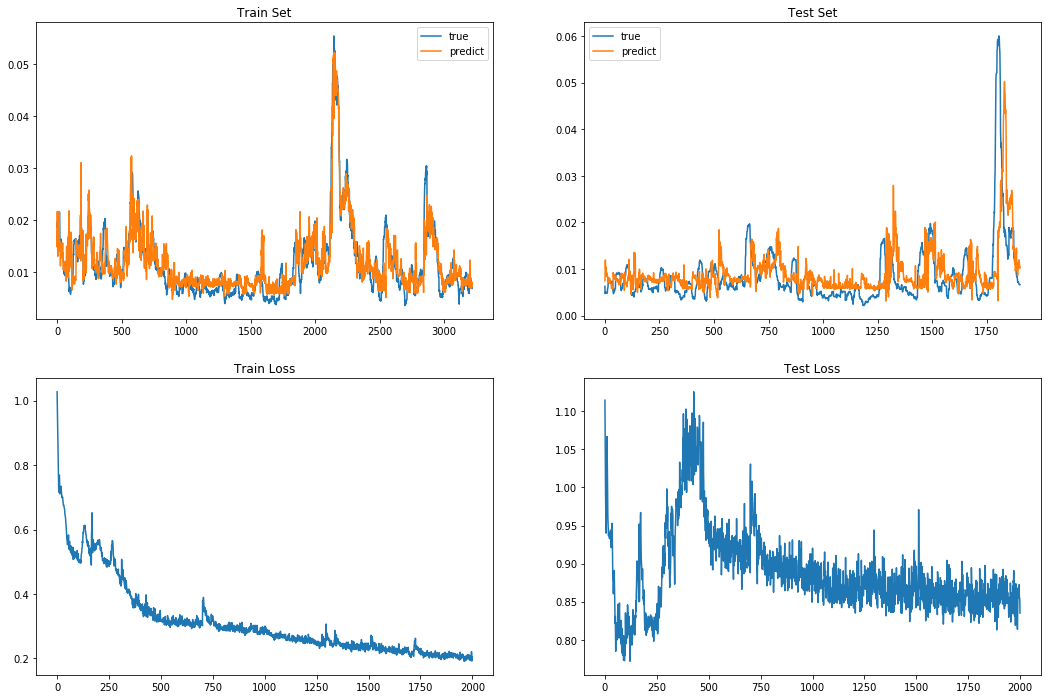

            MAE       MSE      HMAE      HMSE
Train  0.222905  0.103457  0.223650  0.097045
Test   0.376966  0.436082  0.472522  0.401398
Total  0.280167  0.227087  0.316151  0.210167
layer =  2


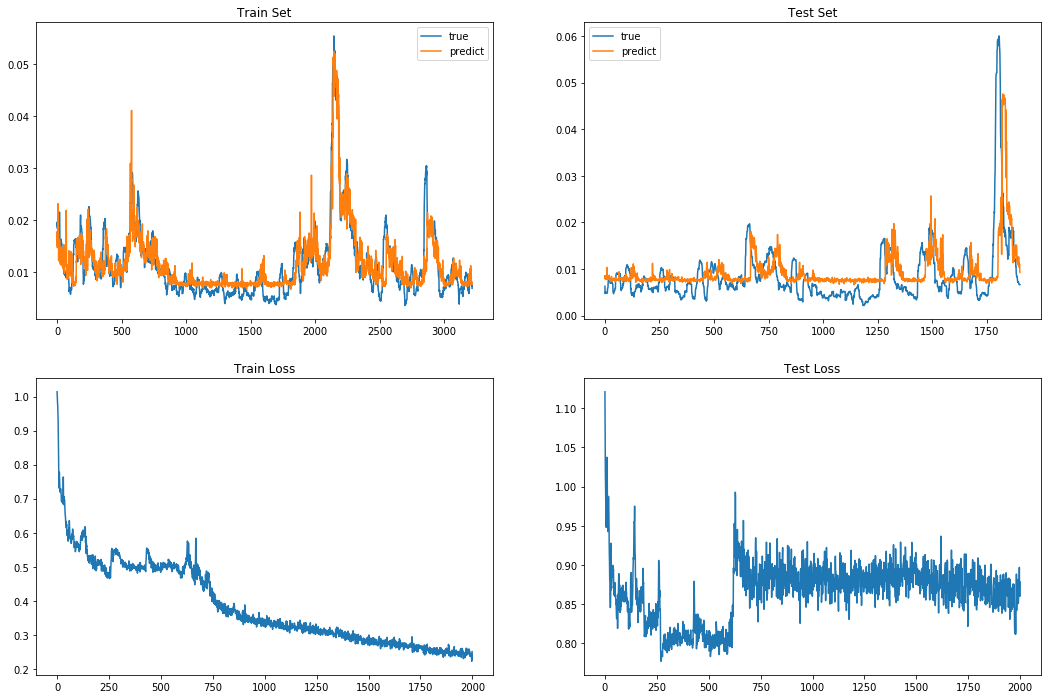

            MAE       MSE      HMAE      HMSE
Train  0.247837  0.126703  0.252882  0.117323
Test   0.387781  0.443836  0.508557  0.438104
Total  0.299852  0.244575  0.347911  0.236551
layer =  3


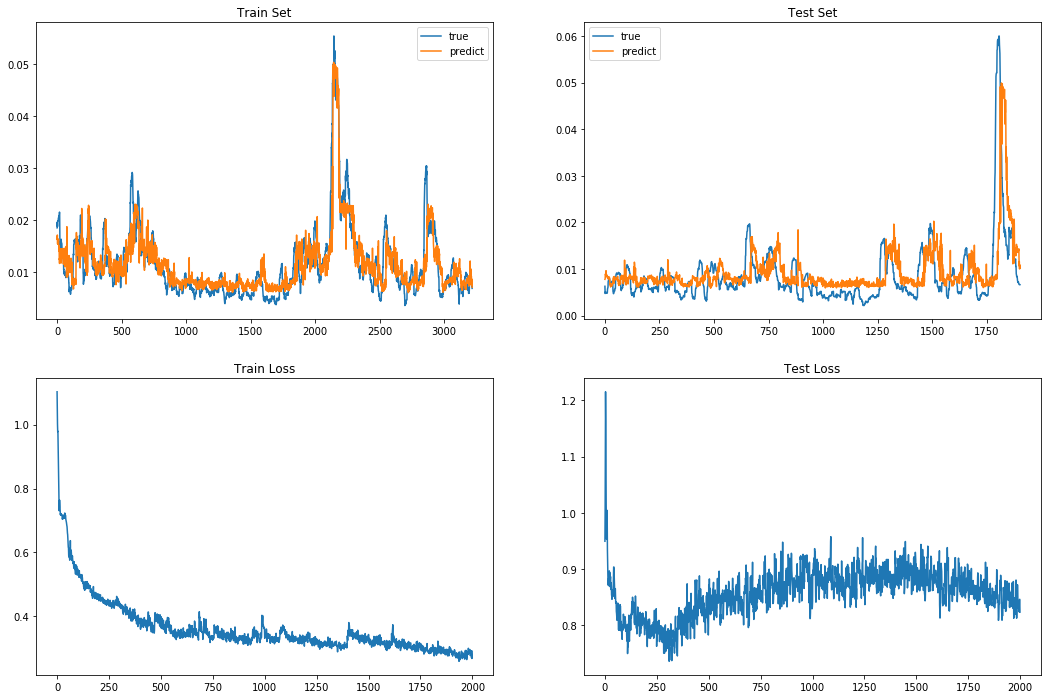

            MAE       MSE      HMAE      HMSE
Train  0.264065  0.136380  0.264272  0.128946
Test   0.376479  0.431970  0.480348  0.400902
Total  0.305847  0.246244  0.344583  0.230026
Rolling Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


            MAE       MSE      HMAE      HMSE
Train  0.263395  0.152789  0.300479  0.169281
Test   0.365952  0.407559  0.475318  0.425917
Total  0.264091  0.154519  0.301667  0.171024
layer =  2
            MAE       MSE      HMAE      HMSE
Train  0.251515  0.137466  0.289423  0.160320
Test   0.410625  0.489041  0.556897  0.590923
Total  0.252596  0.139854  0.291239  0.163245
layer =  3
            MAE       MSE      HMAE      HMSE
Train  0.264661  0.155326  0.301281  0.172386
Test   0.409377  0.531609  0.537059  0.547749
Total  0.265644  0.157882  0.302882  0.174935


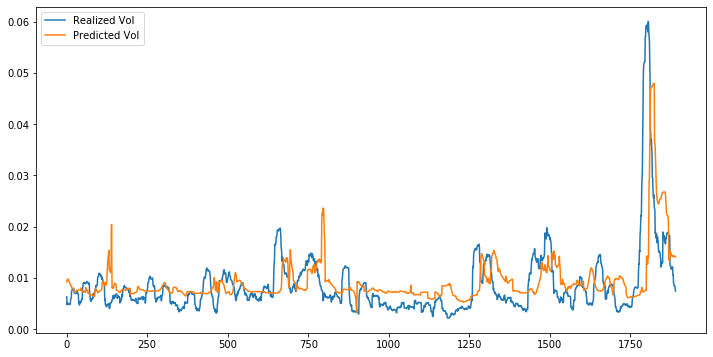

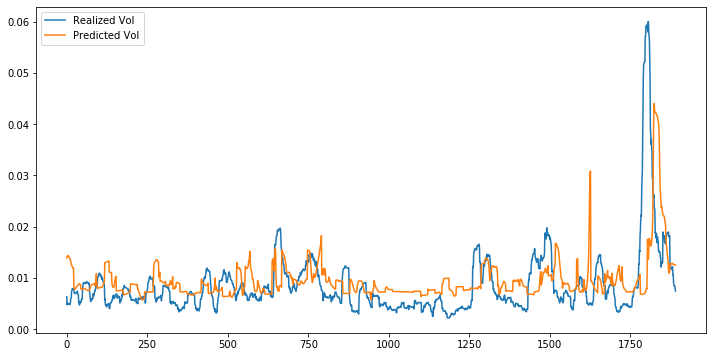

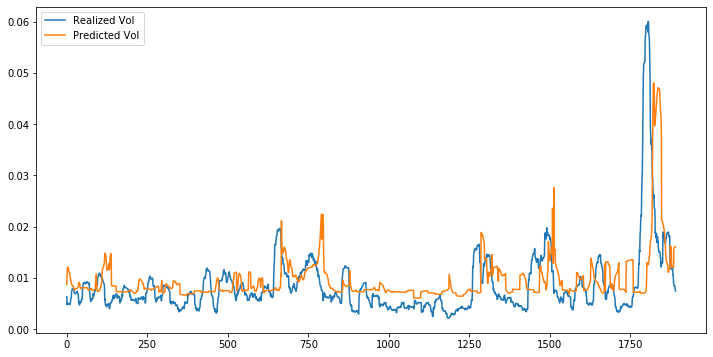

In [4]:
exp_variables = []
plot = False
INPUT_SIZE = len(exp_variables) + 1
HIDDEN_SIZE = 16
print('Split Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    split_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')
print('Rolling Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    rolling_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')

Split Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


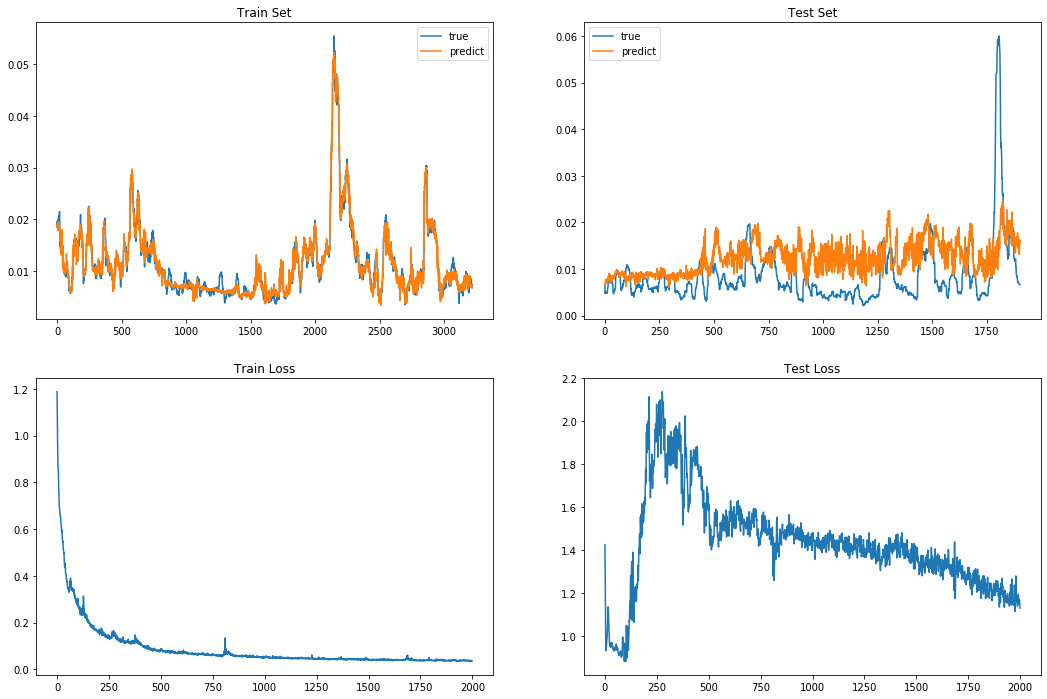

            MAE       MSE      HMAE      HMSE
Train  0.100128  0.017634  0.104464  0.021353
Test   0.558610  0.579783  0.916144  1.566642
Total  0.270537  0.226574  0.406149  0.595705
layer =  2


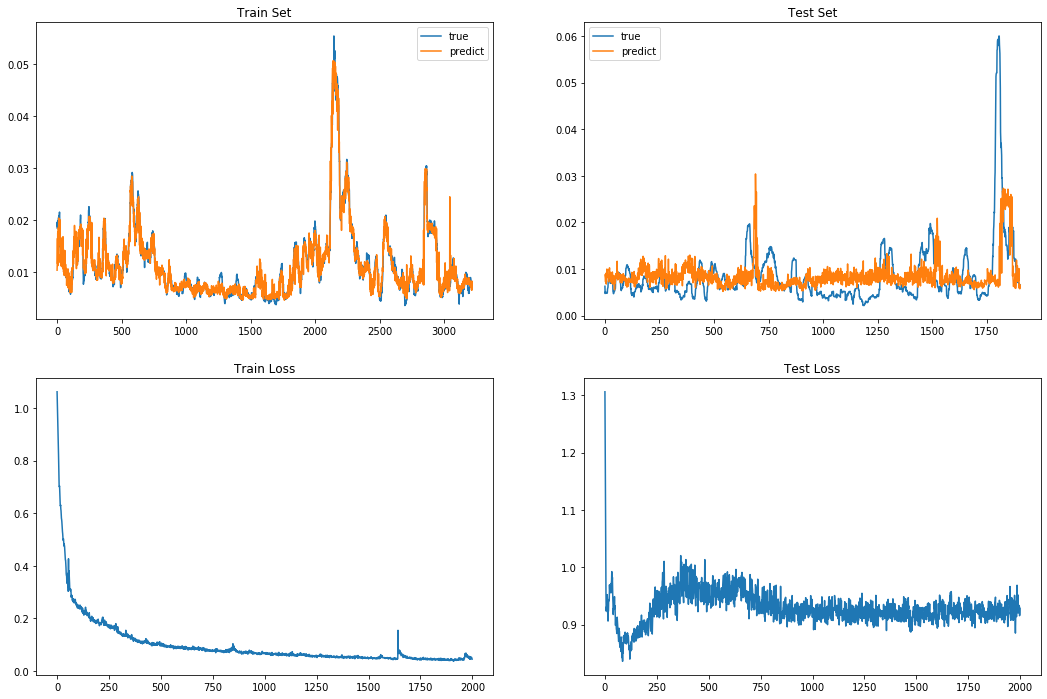

            MAE       MSE      HMAE      HMSE
Train  0.109978  0.022527  0.110466  0.023278
Test   0.387061  0.460868  0.504505  0.453412
Total  0.212964  0.185449  0.256922  0.183151
layer =  3


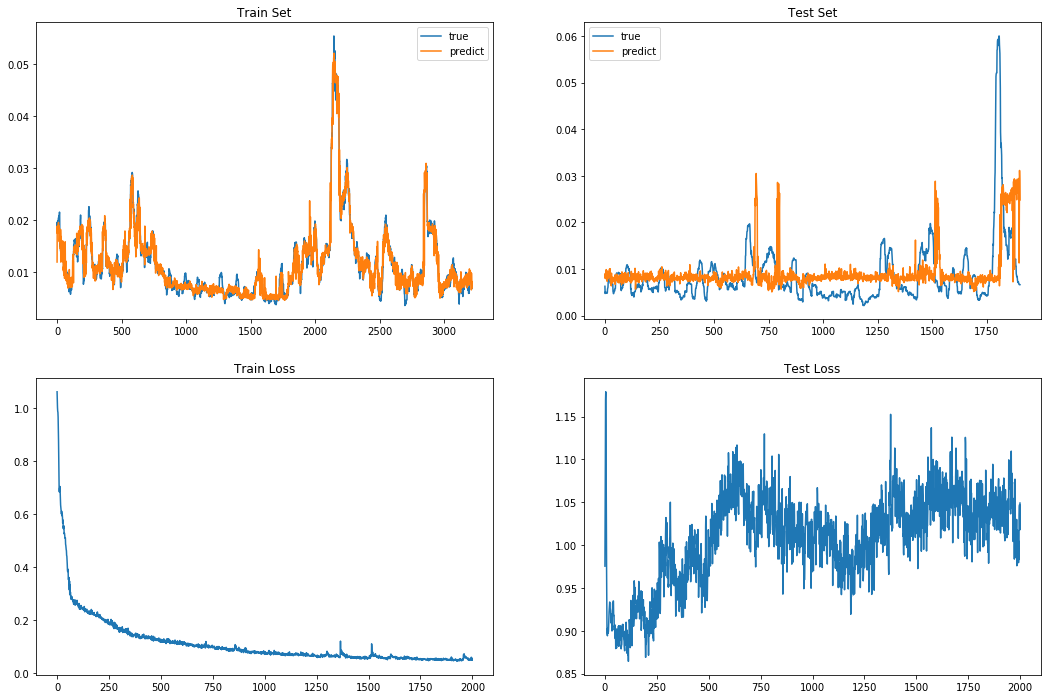

            MAE       MSE      HMAE      HMSE
Train  0.117958  0.024829  0.122406  0.030431
Test   0.417269  0.524101  0.552637  0.591422
Total  0.229206  0.210398  0.282314  0.238940
Rolling Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


            MAE       MSE      HMAE      HMSE
Train  0.121888  0.028353  0.149223  0.047886
Test   0.481376  0.638522  0.632856  0.876364
Total  0.124330  0.032498  0.152508  0.053513
layer =  2
            MAE       MSE      HMAE      HMSE
Train  0.136885  0.034384  0.168173  0.061486
Test   0.473764  0.619213  0.666195  1.012790
Total  0.139173  0.038356  0.171555  0.067947
layer =  3
            MAE       MSE      HMAE      HMSE
Train  0.152410  0.042762  0.186350  0.072283
Test   0.476083  0.572933  0.684627  0.930251
Total  0.154609  0.046363  0.189735  0.078111


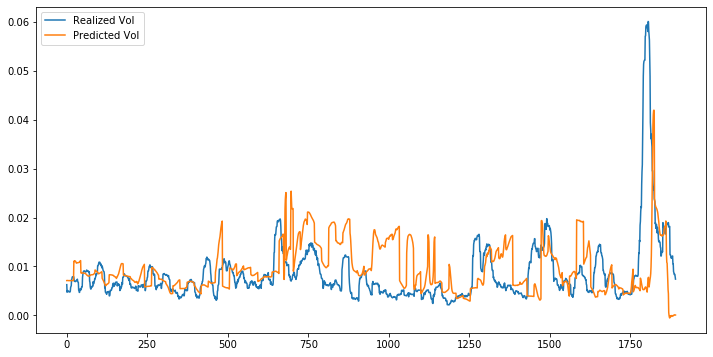

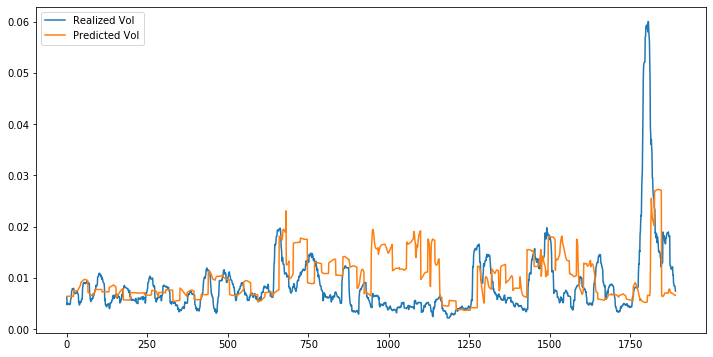

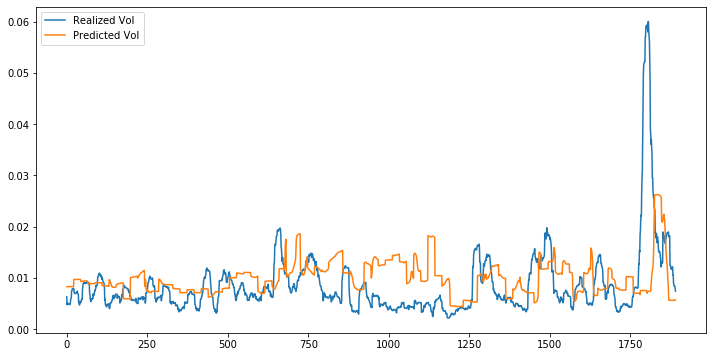

In [5]:
exp_variables = ['us corp bond ytm', 'us gov bond ytm', 'XAU Curncy', 'USCRWTIC Index', ]
plot = False
INPUT_SIZE = len(exp_variables) + 1
HIDDEN_SIZE = 16
print('Split Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    split_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')
print('Rolling Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    rolling_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')
    

Split Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


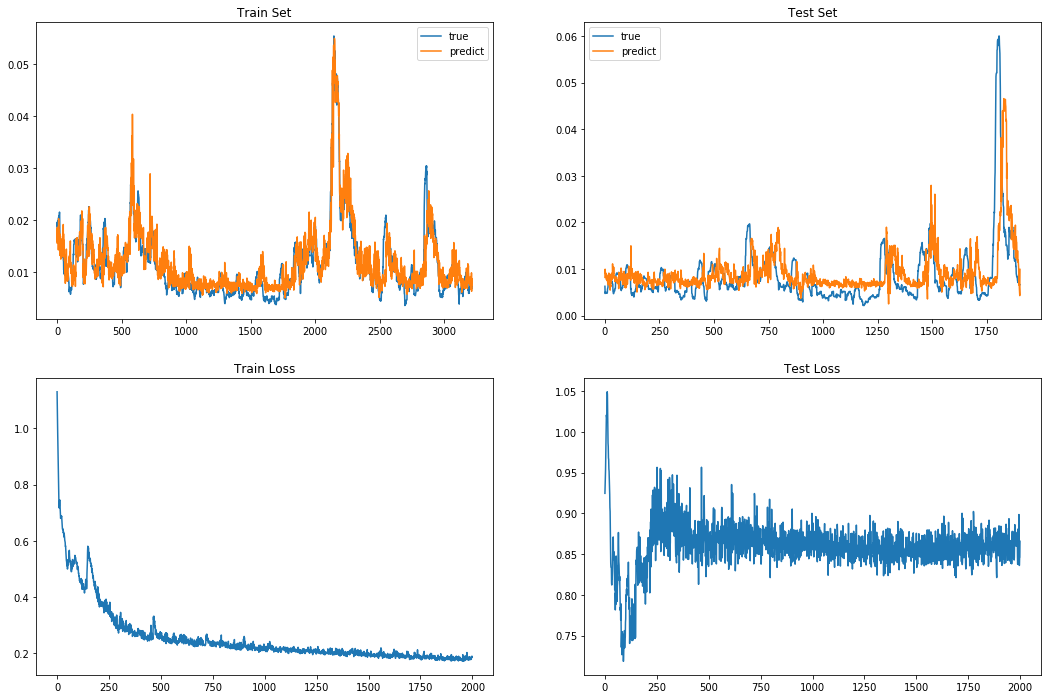

            MAE       MSE      HMAE      HMSE
Train  0.220914  0.094246  0.232039  0.103036
Test   0.374354  0.431174  0.475515  0.388029
Total  0.277945  0.219476  0.322534  0.208962
layer =  2


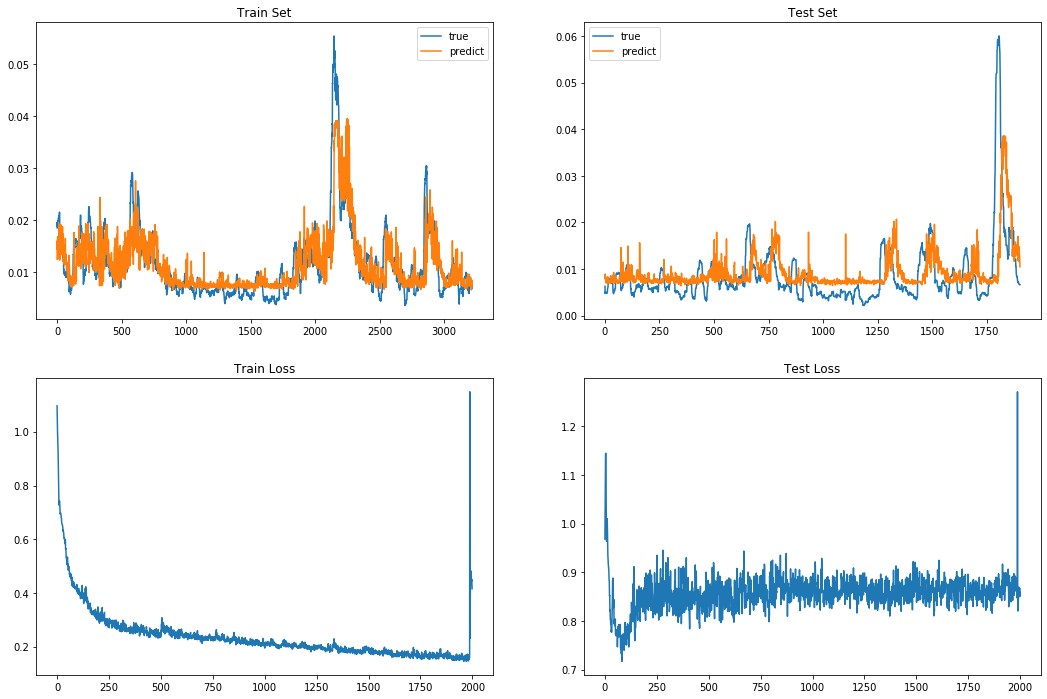

            MAE       MSE      HMAE      HMSE
Train  0.293629  0.209684  0.260661  0.115256
Test   0.379787  0.437016  0.494330  0.421785
Total  0.325652  0.294178  0.347511  0.229187
layer =  3


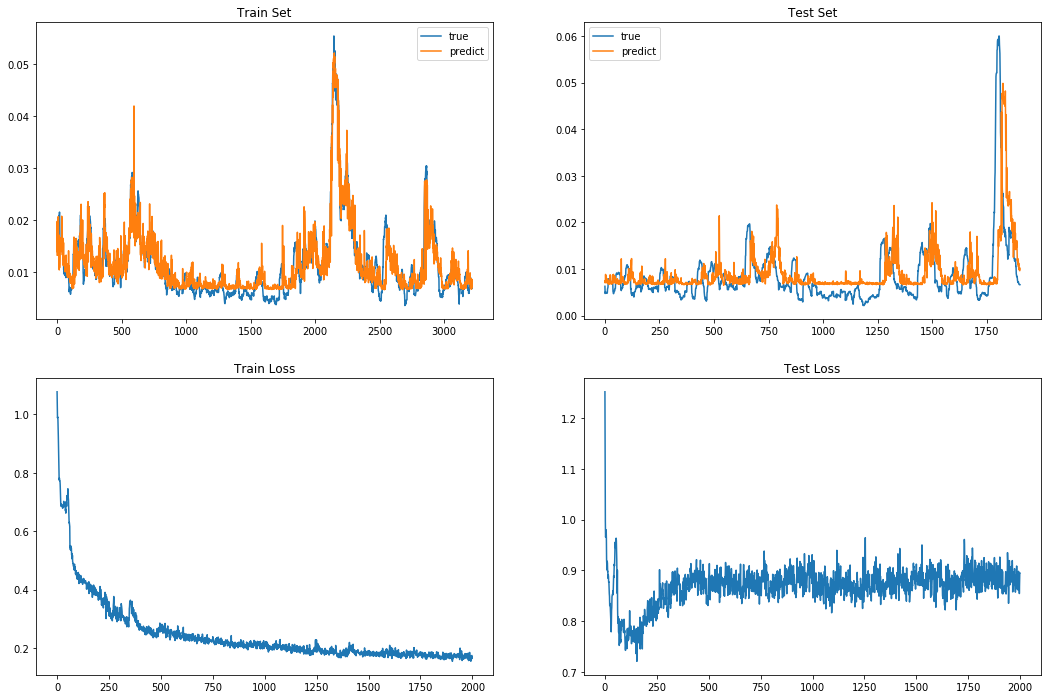

            MAE       MSE      HMAE      HMSE
Train  0.206997  0.083067  0.217988  0.092265
Test   0.375546  0.454946  0.465891  0.374426
Total  0.269643  0.221287  0.310128  0.197139
Rolling Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


            MAE       MSE      HMAE      HMSE
Train  0.222380  0.100021  0.264544  0.133893
Test   0.363534  0.401553  0.468000  0.396152
Total  0.223339  0.102069  0.265926  0.135674
layer =  2
            MAE       MSE      HMAE      HMSE
Train  0.223697  0.101493  0.264547  0.133693
Test   0.389599  0.466373  0.534367  0.672597
Total  0.224824  0.103972  0.266379  0.137353
layer =  3
            MAE       MSE      HMAE      HMSE
Train  0.238352  0.119822  0.277181  0.145134
Test   0.365202  0.395969  0.482716  0.395509
Total  0.239213  0.121698  0.278577  0.146835


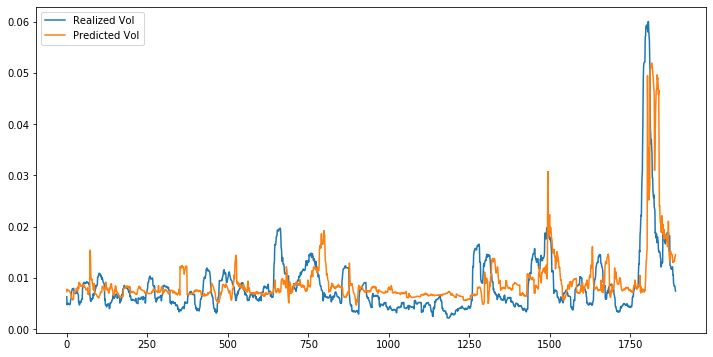

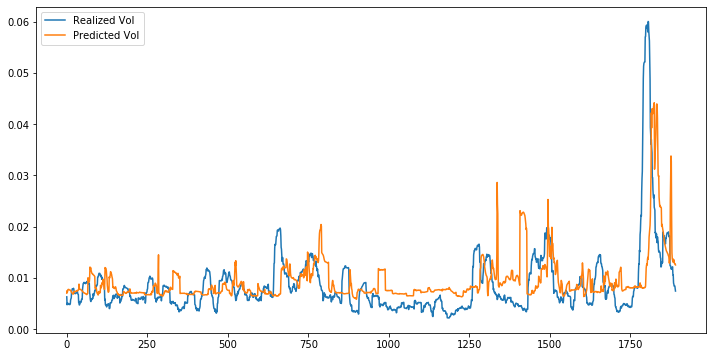

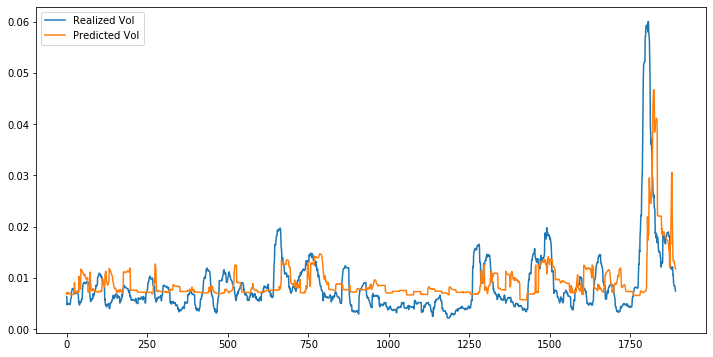

In [6]:
exp_variables = ['garch_cond_vol', 'garch_resid']
plot = False
INPUT_SIZE = len(exp_variables) + 1
HIDDEN_SIZE = 16
print('Split Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    split_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')
print('Rolling Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    rolling_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')

Split Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


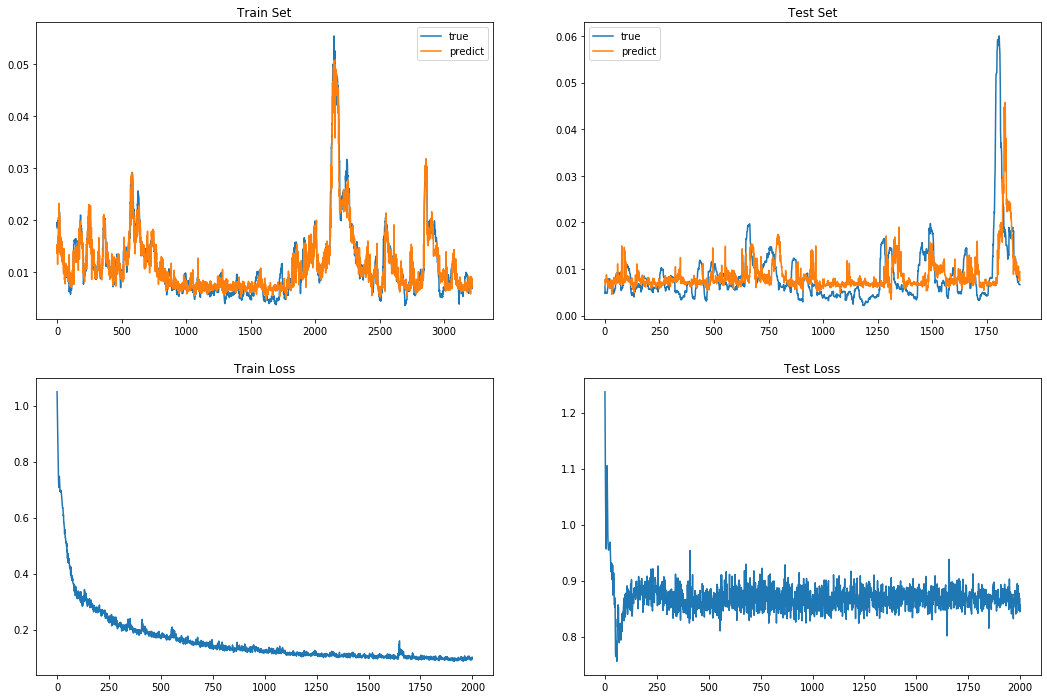

            MAE       MSE      HMAE      HMSE
Train  0.168627  0.051356  0.169643  0.051537
Test   0.362594  0.425122  0.446038  0.339146
Total  0.240720  0.190277  0.272374  0.158435
layer =  2


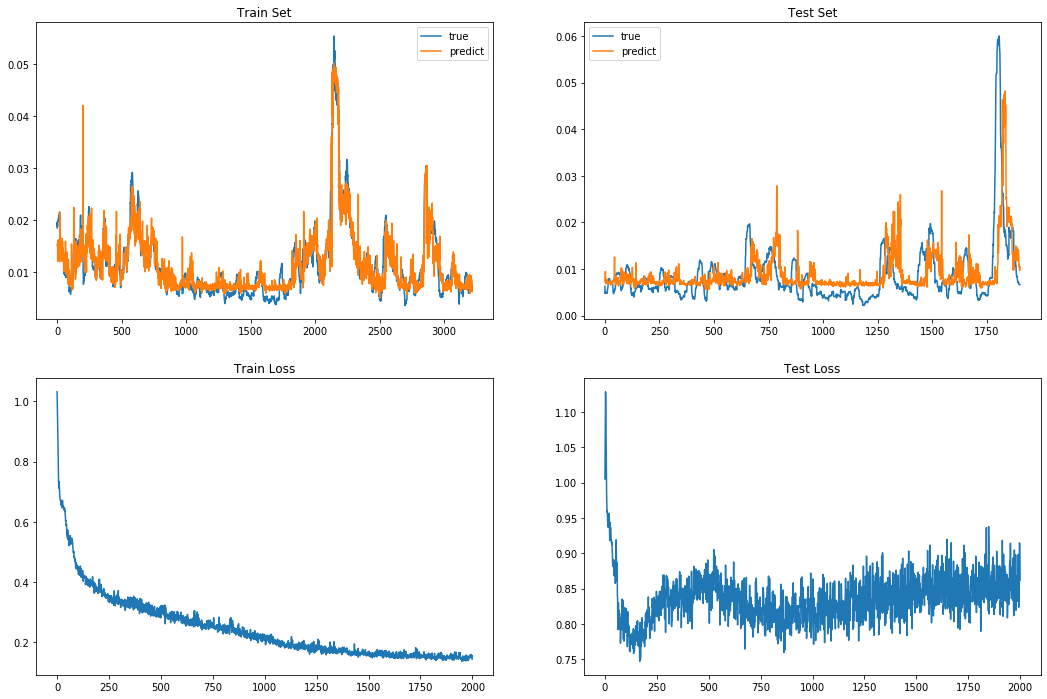

            MAE       MSE      HMAE      HMSE
Train  0.204505  0.072947  0.216952  0.089426
Test   0.374425  0.433848  0.471475  0.401842
Total  0.267661  0.207087  0.311553  0.205545
layer =  3


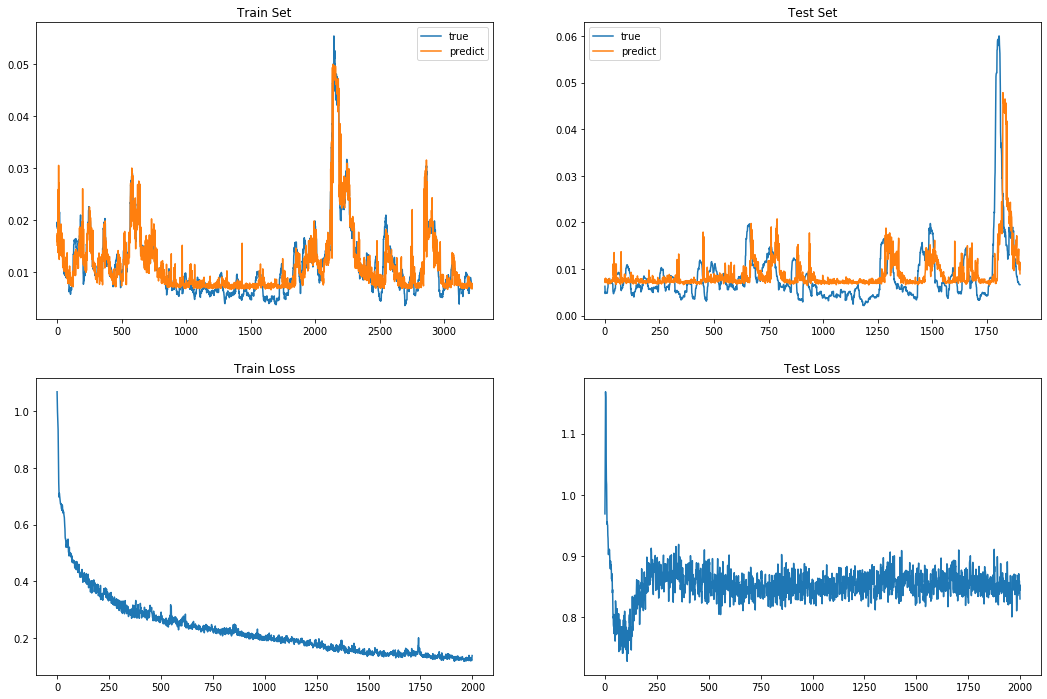

            MAE       MSE      HMAE      HMSE
Train  0.186681  0.069386  0.193931  0.070505
Test   0.371412  0.435359  0.474254  0.390870
Total  0.255342  0.205411  0.298121  0.189578
Rolling Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


            MAE       MSE      HMAE      HMSE
Train  0.194068  0.068818  0.233436  0.104102
Test   0.353132  0.410493  0.438047  0.374843
Total  0.195148  0.071139  0.234826  0.105941
layer =  2
            MAE       MSE      HMAE      HMSE
Train  0.203470  0.077934  0.243446  0.113239
Test   0.334595  0.376911  0.406328  0.289860
Total  0.204360  0.079964  0.244552  0.114439
layer =  3
            MAE       MSE      HMAE      HMSE
Train  0.224521  0.099941  0.263499  0.131052
Test   0.341340  0.377733  0.435142  0.314562
Total  0.225314  0.101828  0.264665  0.132298


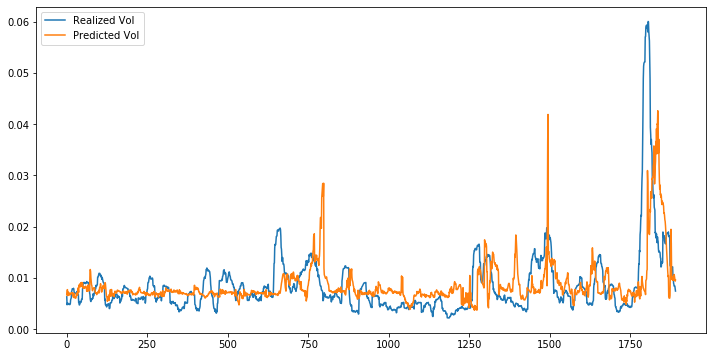

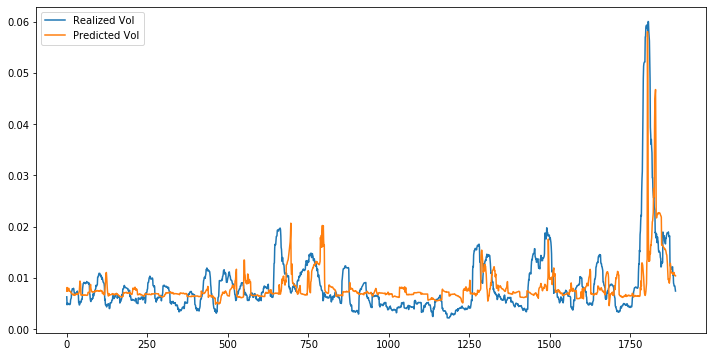

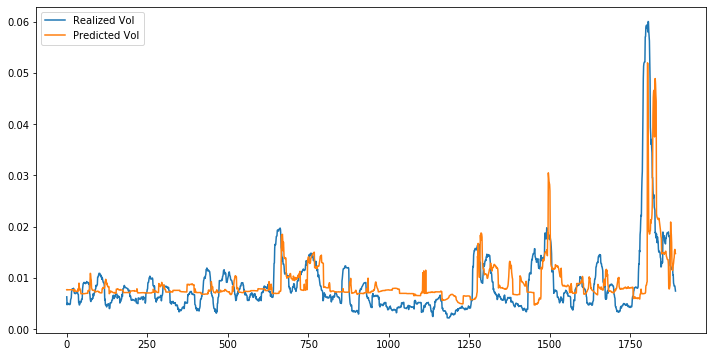

In [7]:
exp_variables = [ 'egarch_cond_vol','egarch_std_resid', 'egarch_asymmetric']
plot = False
INPUT_SIZE = len(exp_variables) + 1
HIDDEN_SIZE = 16
print('Split Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    split_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')
print('Rolling Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    rolling_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')

Split Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


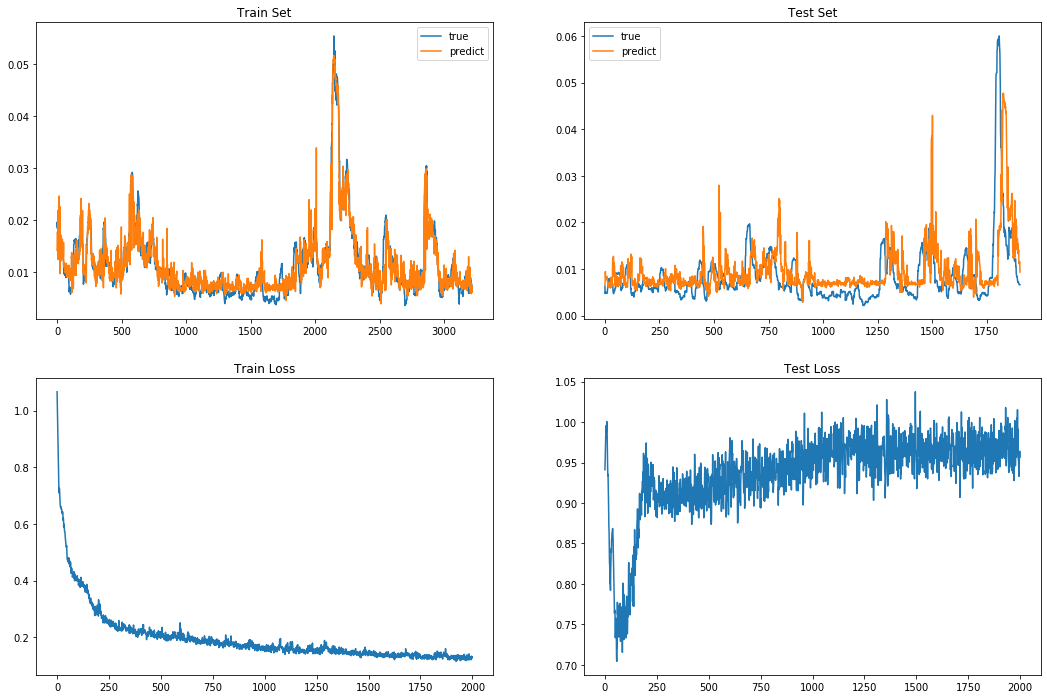

            MAE       MSE      HMAE      HMSE
Train  0.187316  0.066231  0.200472  0.085093
Test   0.408783  0.499253  0.517852  0.489479
Total  0.269631  0.227177  0.318436  0.235395
layer =  2


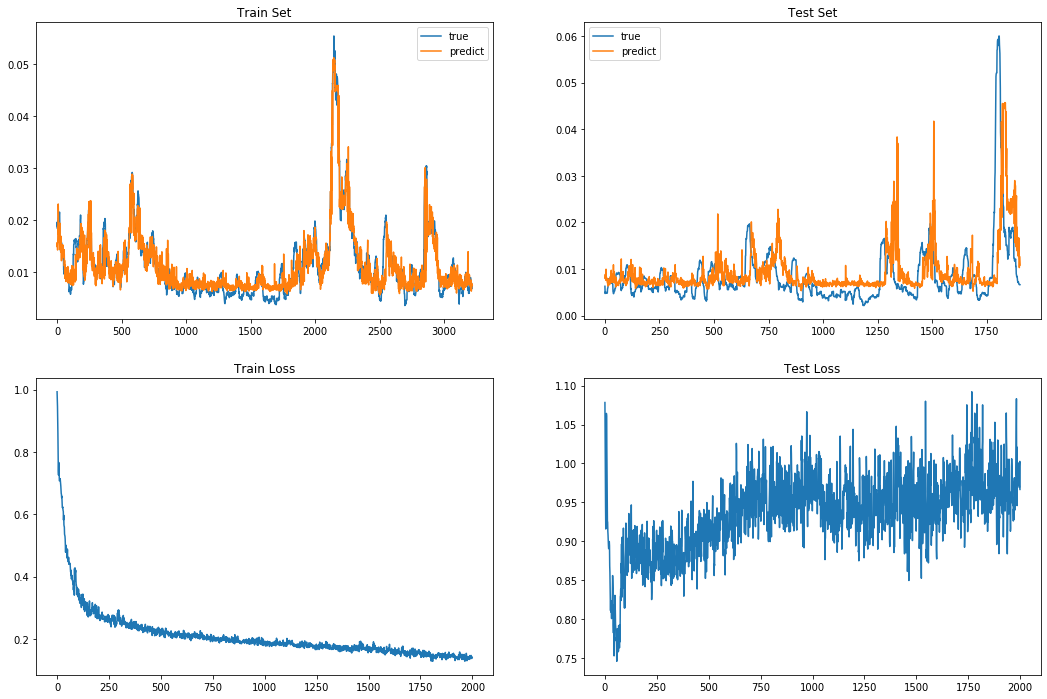

            MAE       MSE      HMAE      HMSE
Train  0.192789  0.071392  0.208411  0.085121
Test   0.394695  0.479079  0.490372  0.429520
Total  0.267834  0.222921  0.313210  0.213127
layer =  3


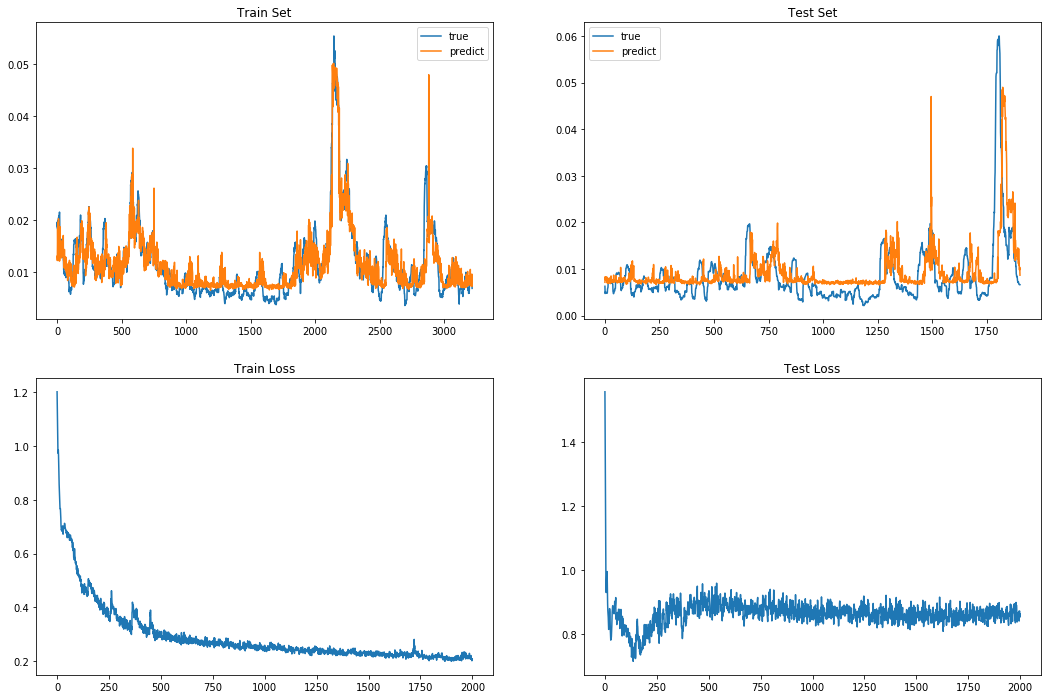

            MAE       MSE      HMAE      HMSE
Train  0.229676  0.104738  0.237718  0.103819
Test   0.371950  0.440565  0.470184  0.374940
Total  0.282557  0.229558  0.324121  0.204589
Rolling Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


            MAE       MSE      HMAE      HMSE
Train  0.217788  0.096782  0.260418  0.130407
Test   0.373607  0.439056  0.467056  0.389923
Total  0.218846  0.099107  0.261822  0.132170
layer =  2
            MAE       MSE      HMAE      HMSE
Train  0.219706  0.096536  0.262482  0.133006
Test   0.388039  0.415039  0.523672  0.603051
Total  0.220849  0.098700  0.264257  0.136198
layer =  3
            MAE       MSE      HMAE      HMSE
Train  0.236761  0.118795  0.276255  0.144514
Test   0.367029  0.369462  0.493849  0.431730
Total  0.237646  0.120498  0.277733  0.146465


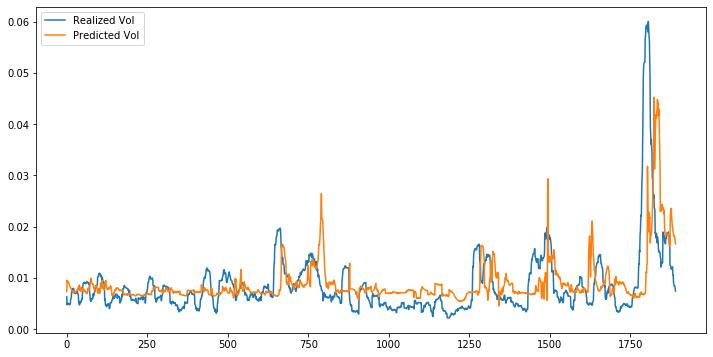

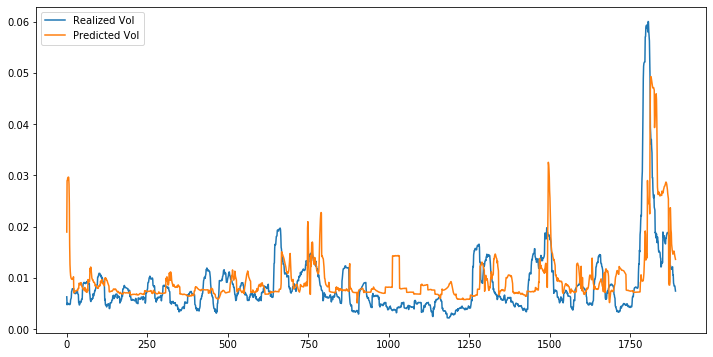

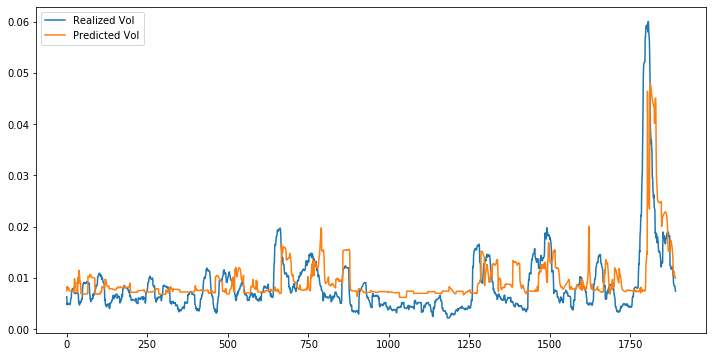

In [8]:
exp_variables = ['ewma_cond_vol', 'ewma_resid']
plot = False
INPUT_SIZE = len(exp_variables) + 1
HIDDEN_SIZE = 16
print('Split Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    split_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')
print('Rolling Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    rolling_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')

Split Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


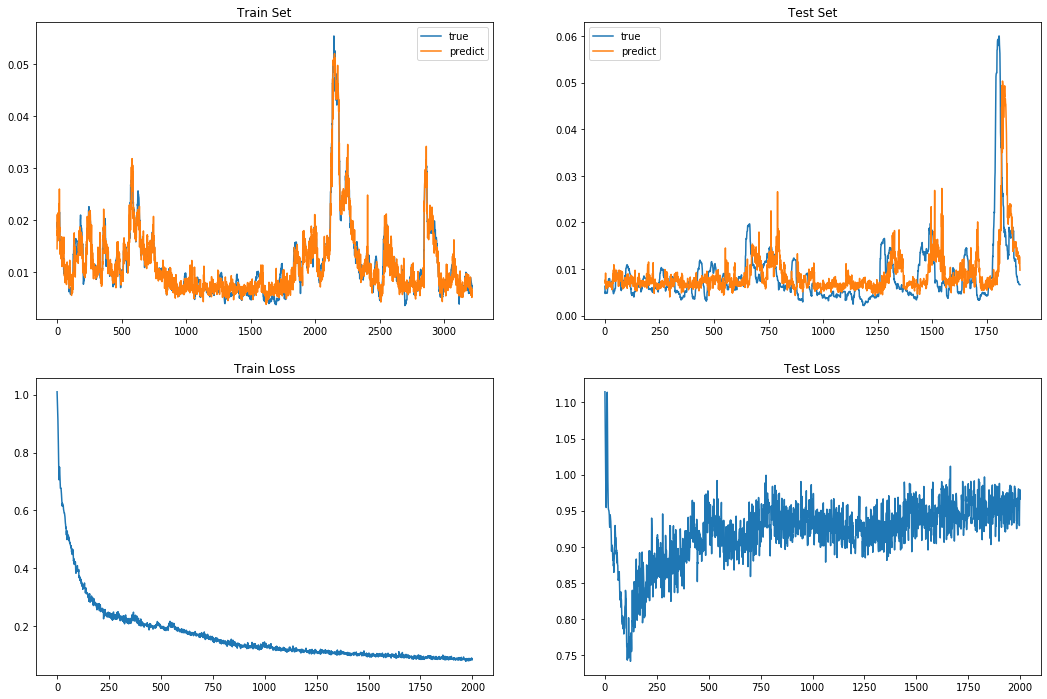

            MAE       MSE      HMAE      HMSE
Train  0.156232  0.041579  0.170963  0.058553
Test   0.385458  0.485211  0.471469  0.421814
Total  0.241431  0.206468  0.282655  0.193570
layer =  2


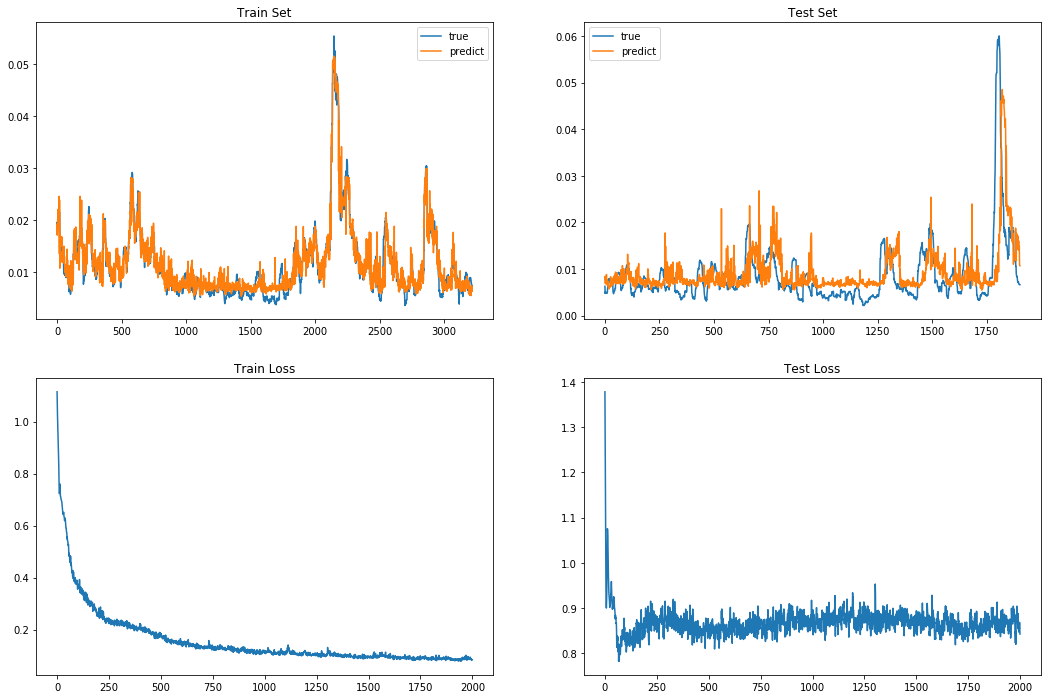

            MAE       MSE      HMAE      HMSE
Train  0.153379  0.042292  0.161378  0.050123
Test   0.374581  0.440565  0.474278  0.397237
Total  0.235595  0.190322  0.277676  0.179138
layer =  3


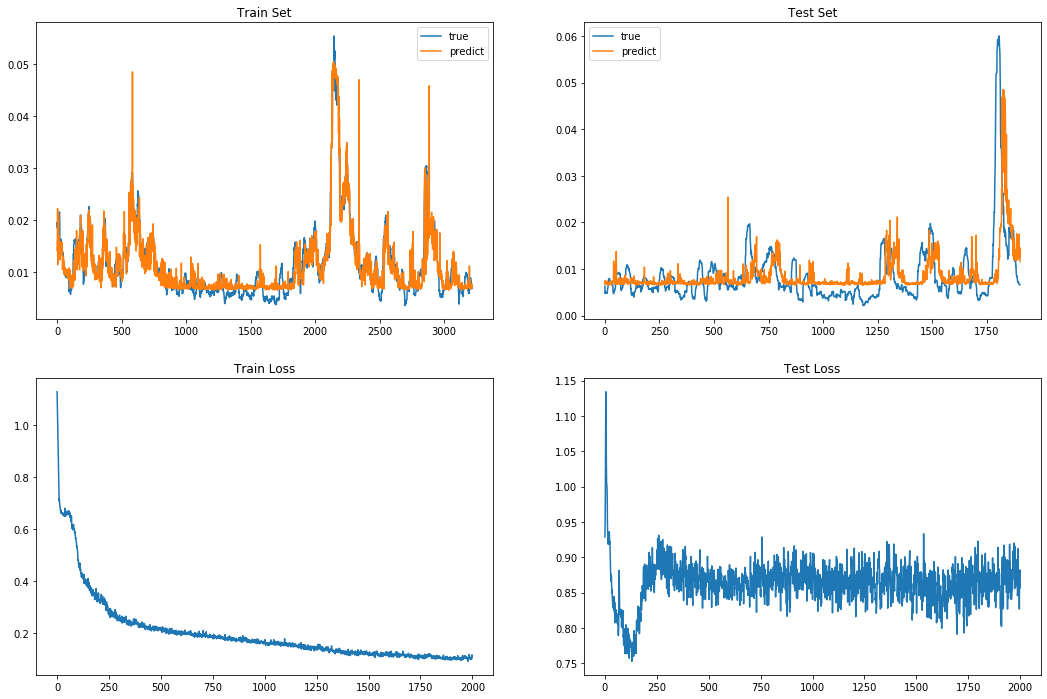

            MAE       MSE      HMAE      HMSE
Train  0.174925  0.055292  0.182638  0.063454
Test   0.361087  0.441242  0.441844  0.334247
Total  0.244118  0.198742  0.278980  0.164102
Rolling Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


            MAE       MSE      HMAE      HMSE
Train  0.175846  0.055577  0.214107  0.088176
Test   0.333900  0.376185  0.405903  0.298307
Total  0.176920  0.057755  0.215410  0.089604
layer =  2
            MAE       MSE      HMAE      HMSE
Train  0.186204  0.063448  0.225085  0.097470
Test   0.334475  0.364369  0.404634  0.292869
Total  0.187211  0.065492  0.226304  0.098798
layer =  3
            MAE       MSE      HMAE      HMSE
Train  0.210416  0.085890  0.250195  0.119315
Test   0.357617  0.384065  0.464004  0.376564
Total  0.211416  0.087916  0.251647  0.121062


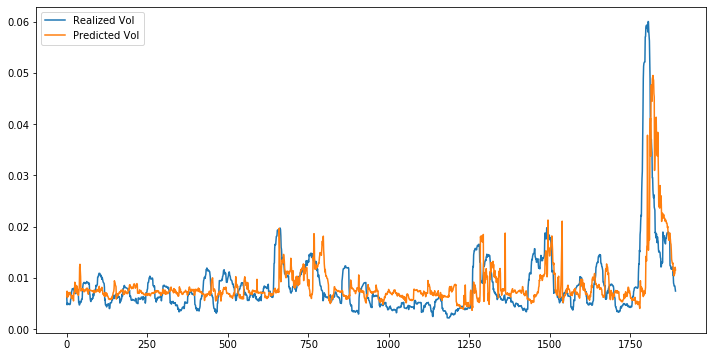

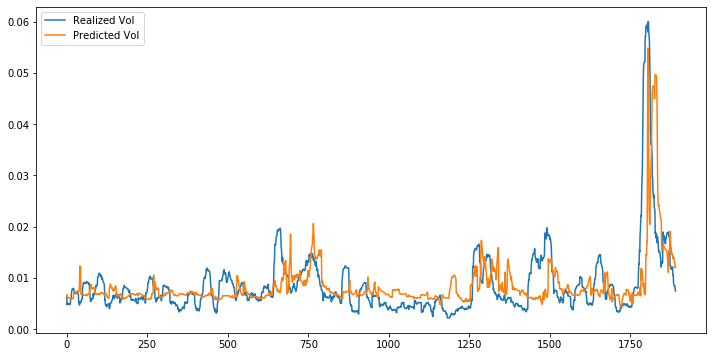

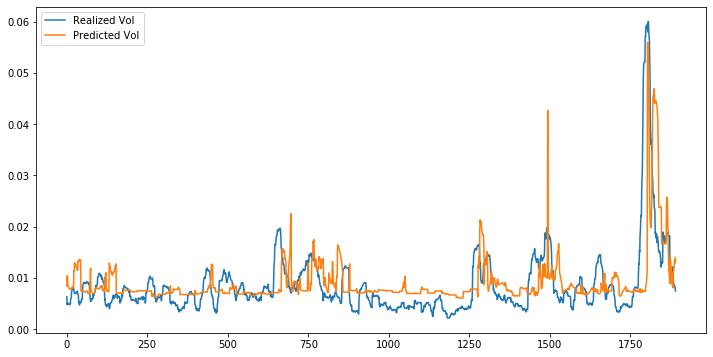

In [9]:
exp_variables = ['garch_cond_vol', 'garch_resid', 'egarch_cond_vol','egarch_std_resid', 'egarch_asymmetric']
plot = False
INPUT_SIZE = len(exp_variables) + 1
HIDDEN_SIZE = 16
print('Split Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    split_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')
print('Rolling Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    rolling_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')

Split Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


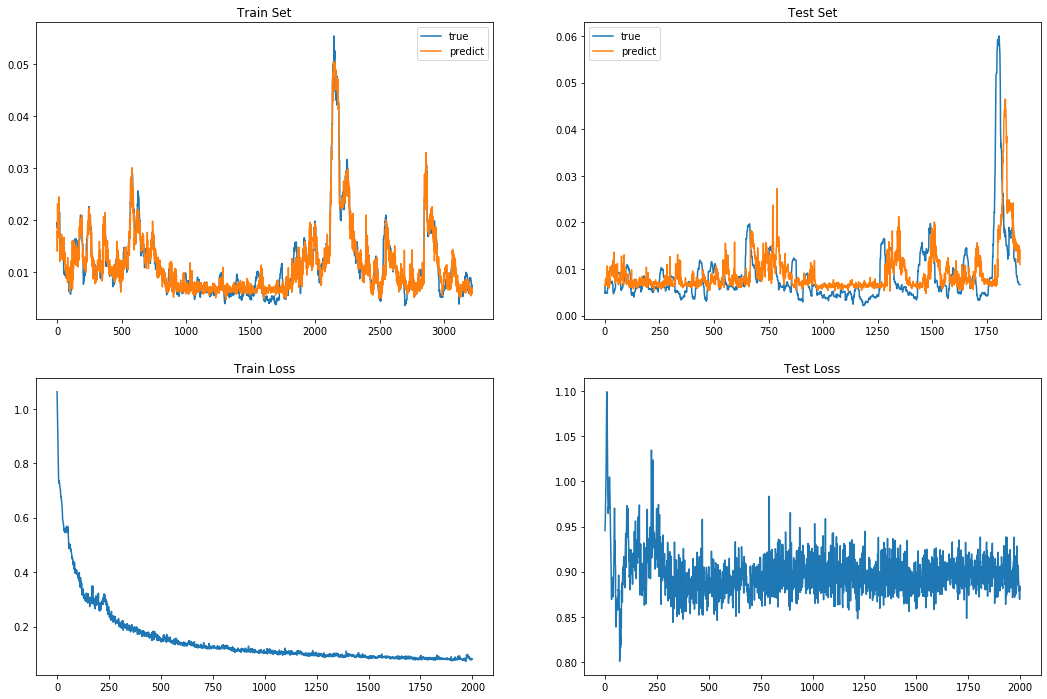

            MAE       MSE      HMAE      HMSE
Train  0.148246  0.041111  0.156674  0.050108
Test   0.383957  0.446387  0.478136  0.403299
Total  0.235855  0.191744  0.276155  0.181382
layer =  2


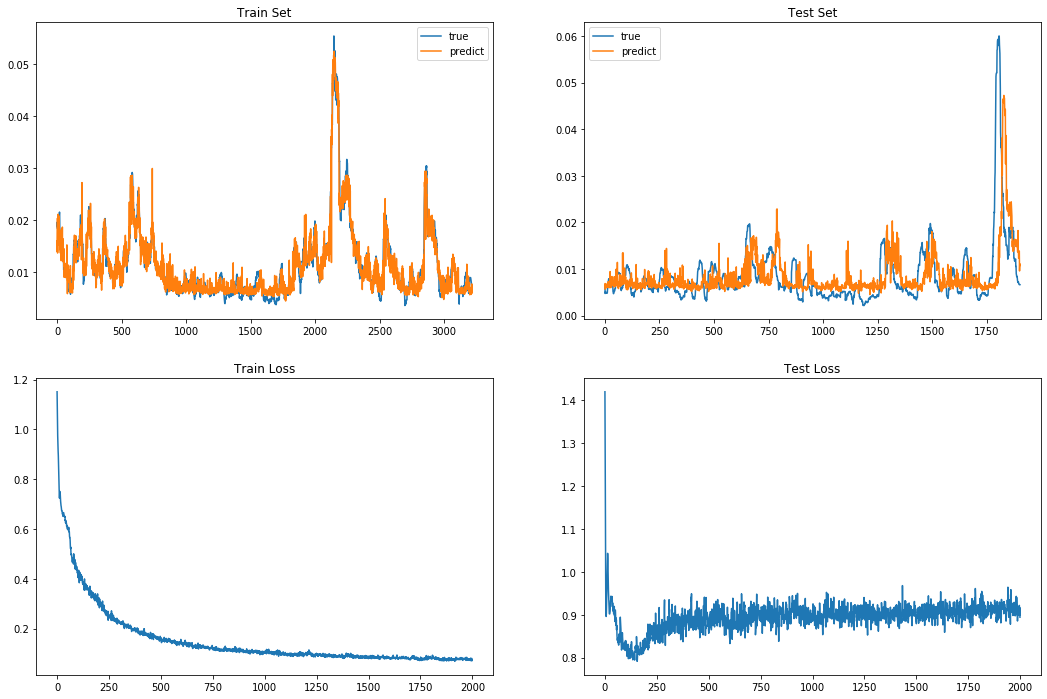

            MAE       MSE      HMAE      HMSE
Train  0.143848  0.037966  0.152510  0.046132
Test   0.365656  0.456407  0.422877  0.308481
Total  0.226290  0.193492  0.253000  0.143642
layer =  3


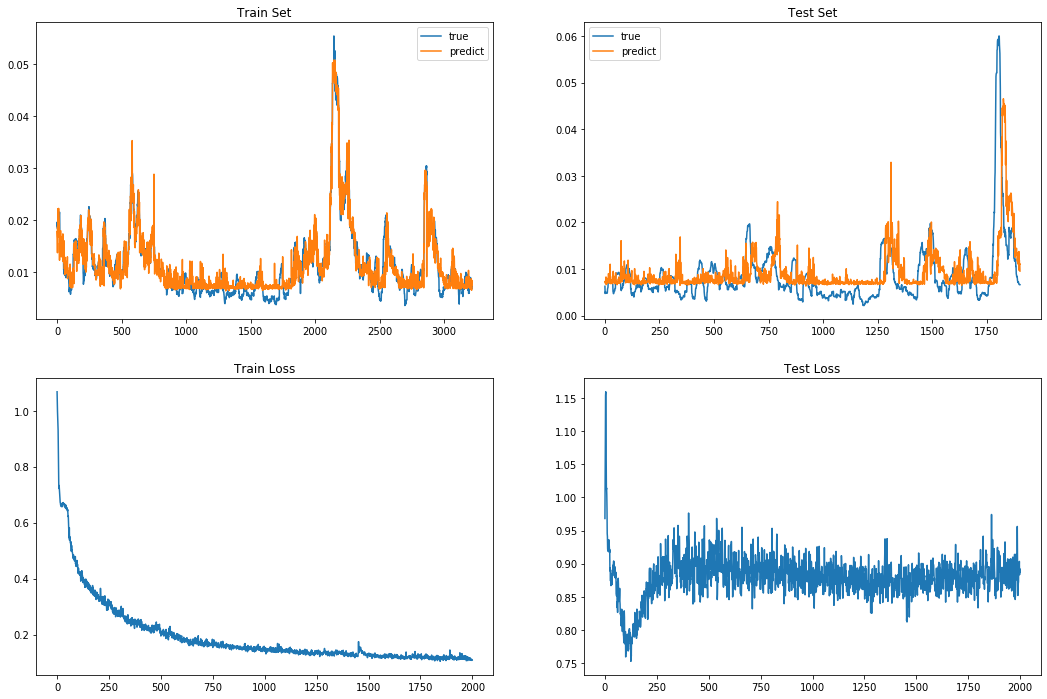

            MAE       MSE      HMAE      HMSE
Train  0.176166  0.055071  0.193637  0.073854
Test   0.383301  0.444613  0.487423  0.404273
Total  0.253154  0.199856  0.302831  0.196664
Rolling Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


            MAE       MSE      HMAE      HMSE
Train  0.180107  0.059927  0.219232  0.094022
Test   0.365631  0.432127  0.435424  0.335547
Total  0.181367  0.062455  0.220700  0.095663
layer =  2
            MAE       MSE      HMAE      HMSE
Train  0.186467  0.063790  0.225354  0.098080
Test   0.326368  0.362271  0.413512  0.332184
Total  0.187417  0.065818  0.226632  0.099670
layer =  3
            MAE       MSE      HMAE      HMSE
Train  0.209717  0.083895  0.249518  0.118094
Test   0.340965  0.347487  0.457308  0.380539
Total  0.210609  0.085686  0.250930  0.119877


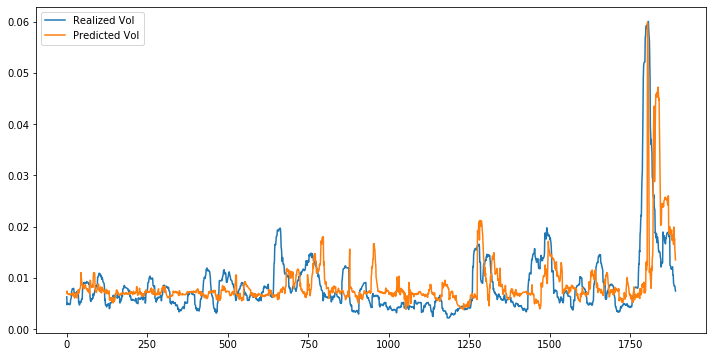

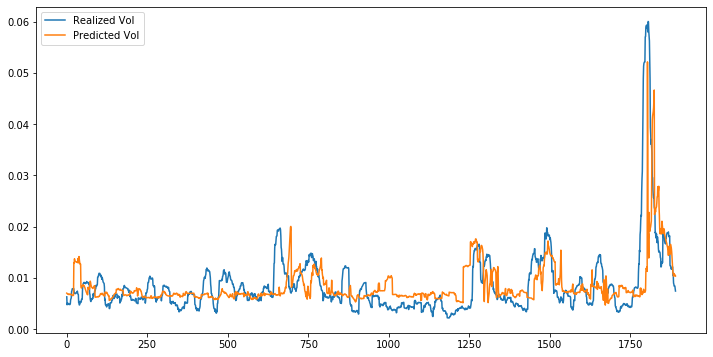

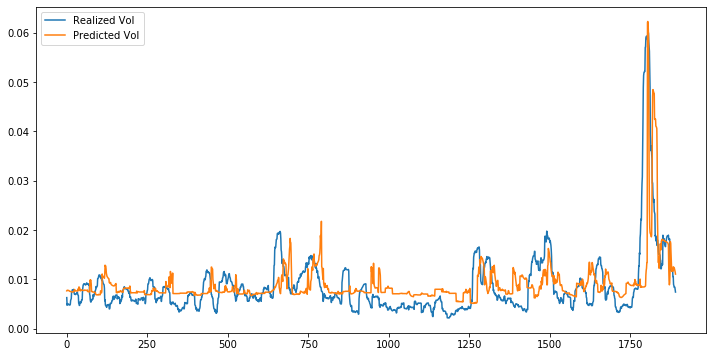

In [10]:
exp_variables = ['egarch_cond_vol','egarch_std_resid', 'egarch_asymmetric', 'ewma_cond_vol', 'ewma_resid']
plot = False
INPUT_SIZE = len(exp_variables) + 1
HIDDEN_SIZE = 16
print('Split Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    split_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')
print('Rolling Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    rolling_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')

Split Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


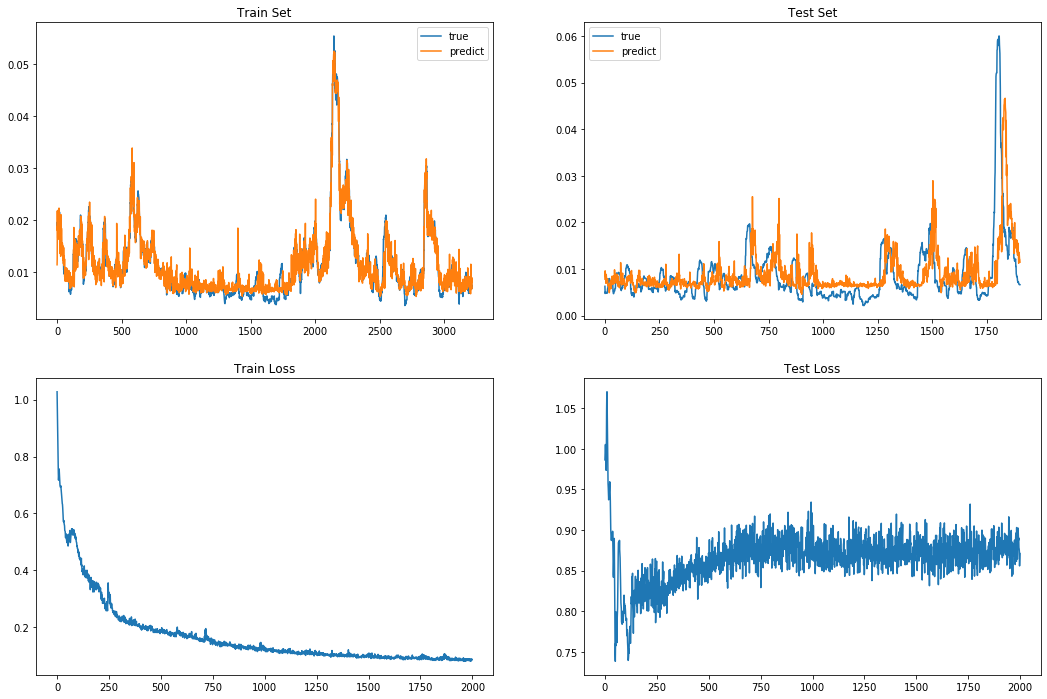

            MAE       MSE      HMAE      HMSE
Train  0.154284  0.043409  0.164986  0.053239
Test   0.375826  0.445676  0.456650  0.364151
Total  0.236627  0.192924  0.273392  0.168799
layer =  2


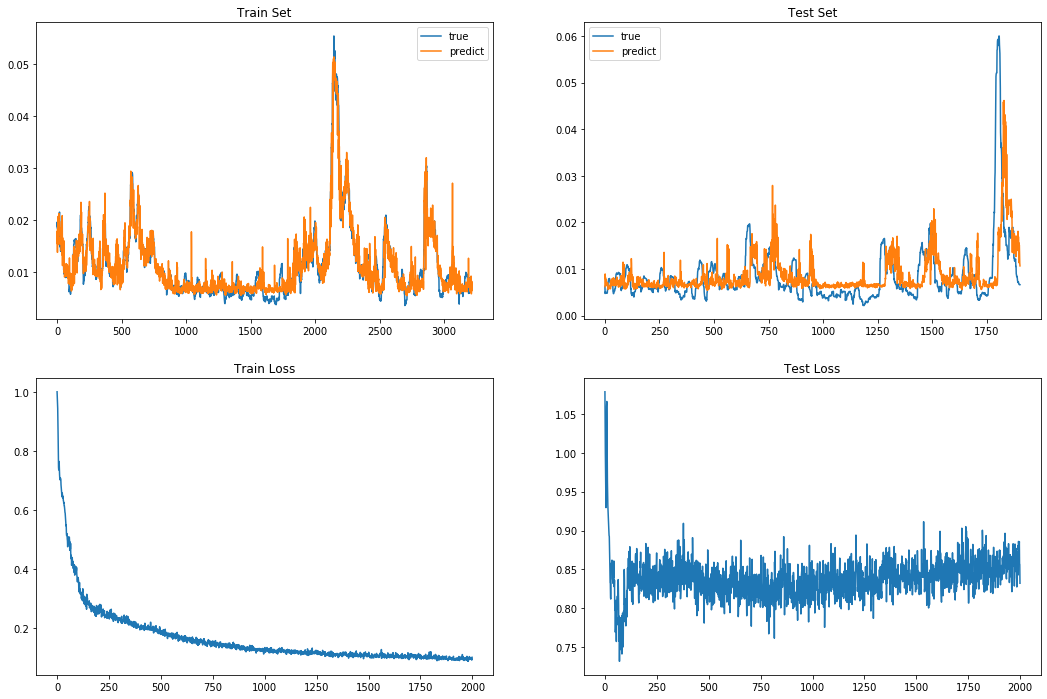

            MAE       MSE      HMAE      HMSE
Train  0.162999  0.050452  0.173079  0.061660
Test   0.356804  0.424475  0.437243  0.370684
Total  0.235032  0.189469  0.271263  0.176518
layer =  3


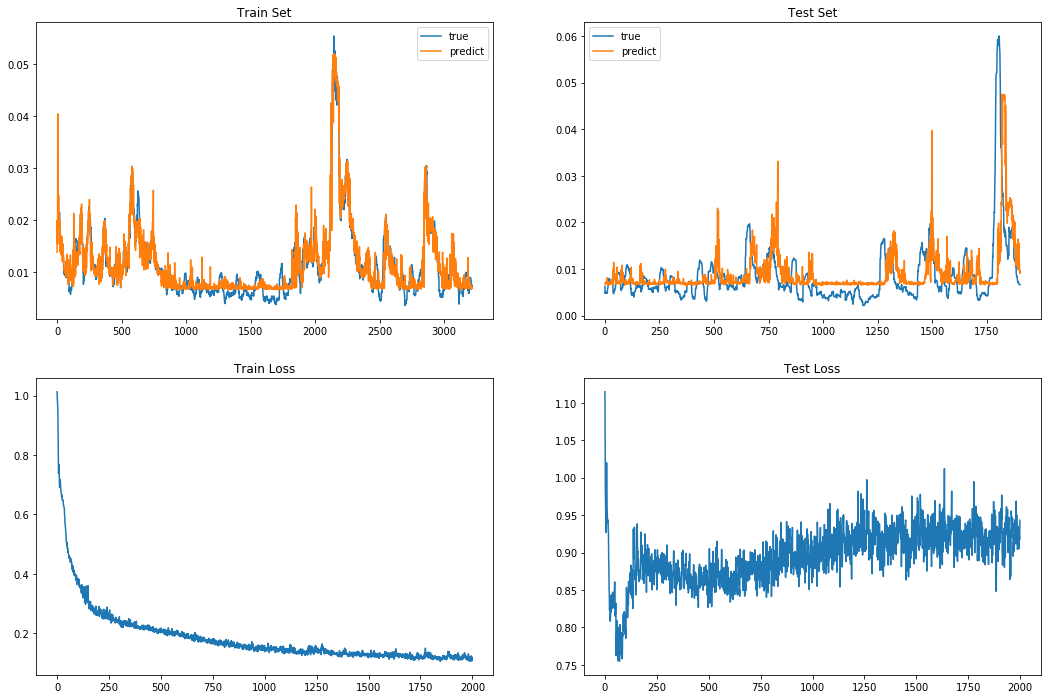

            MAE       MSE      HMAE      HMSE
Train  0.183646  0.059461  0.200561  0.078710
Test   0.373715  0.457418  0.458397  0.363605
Total  0.254291  0.207374  0.296393  0.184600
Rolling Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


            MAE       MSE      HMAE      HMSE
Train  0.194426  0.072555  0.234811  0.106383
Test   0.335553  0.329812  0.415952  0.294471
Total  0.195385  0.074302  0.236041  0.107660
layer =  2
            MAE       MSE      HMAE      HMSE
Train  0.199847  0.077847  0.240494  0.112070
Test   0.357692  0.429019  0.436865  0.337708
Total  0.200919  0.080232  0.241828  0.113602
layer =  3
            MAE       MSE      HMAE      HMSE
Train  0.221248  0.098729  0.262302  0.131199
Test   0.361183  0.409886  0.474044  0.435057
Total  0.222198  0.100842  0.263740  0.133263


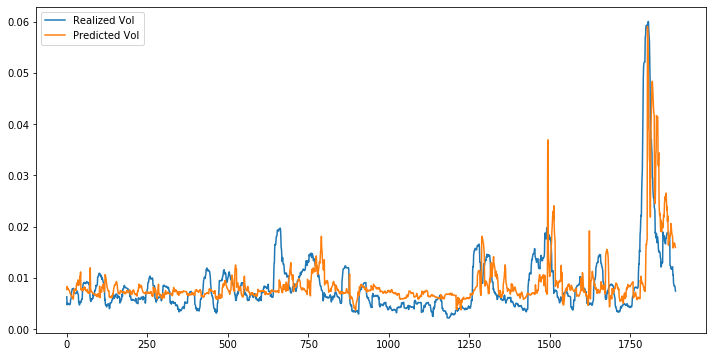

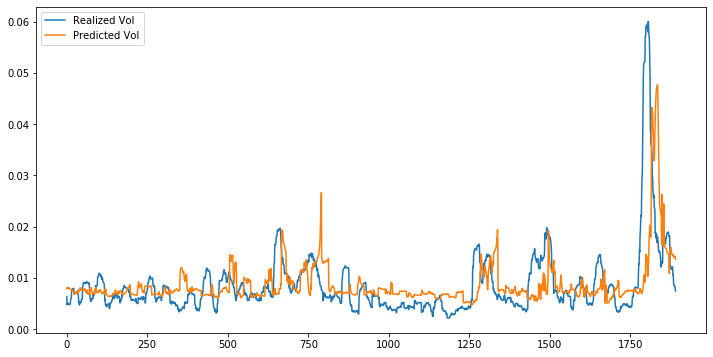

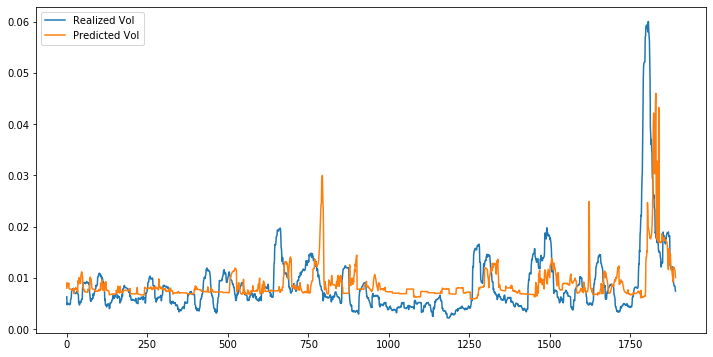

In [11]:
exp_variables = ['garch_cond_vol', 'garch_resid', 'ewma_cond_vol', 'ewma_resid']
plot = False
INPUT_SIZE = len(exp_variables) + 1
HIDDEN_SIZE = 16
print('Split Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    split_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')
print('Rolling Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    rolling_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')

Split Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


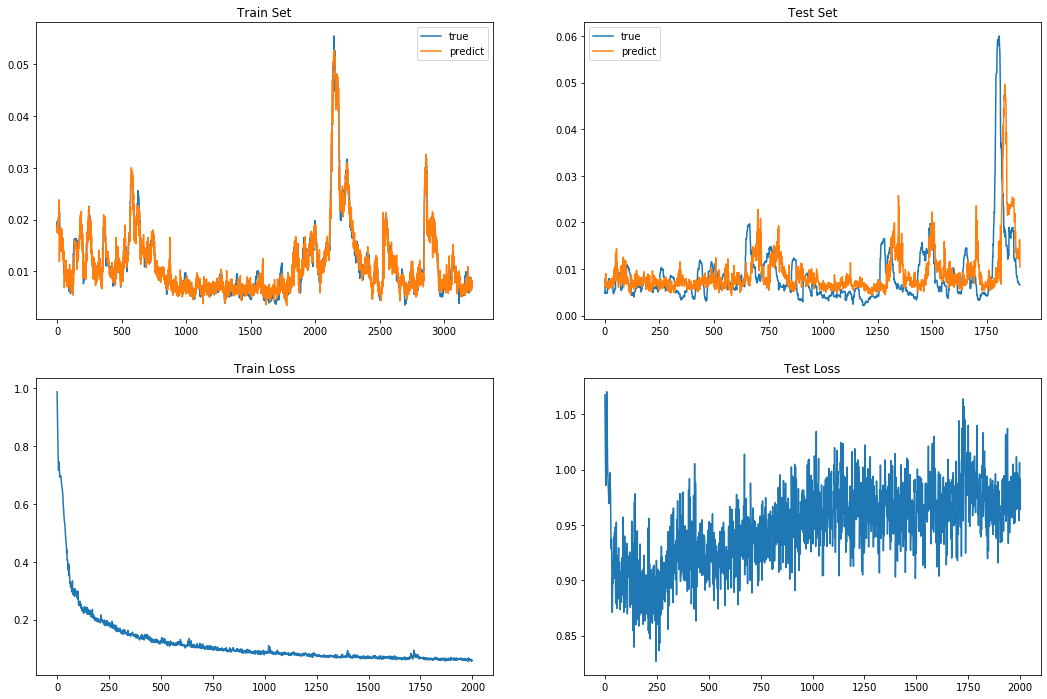

            MAE       MSE      HMAE      HMSE
Train  0.132064  0.029842  0.139926  0.036577
Test   0.395947  0.499883  0.483070  0.428979
Total  0.230144  0.204547  0.267465  0.182425
layer =  2


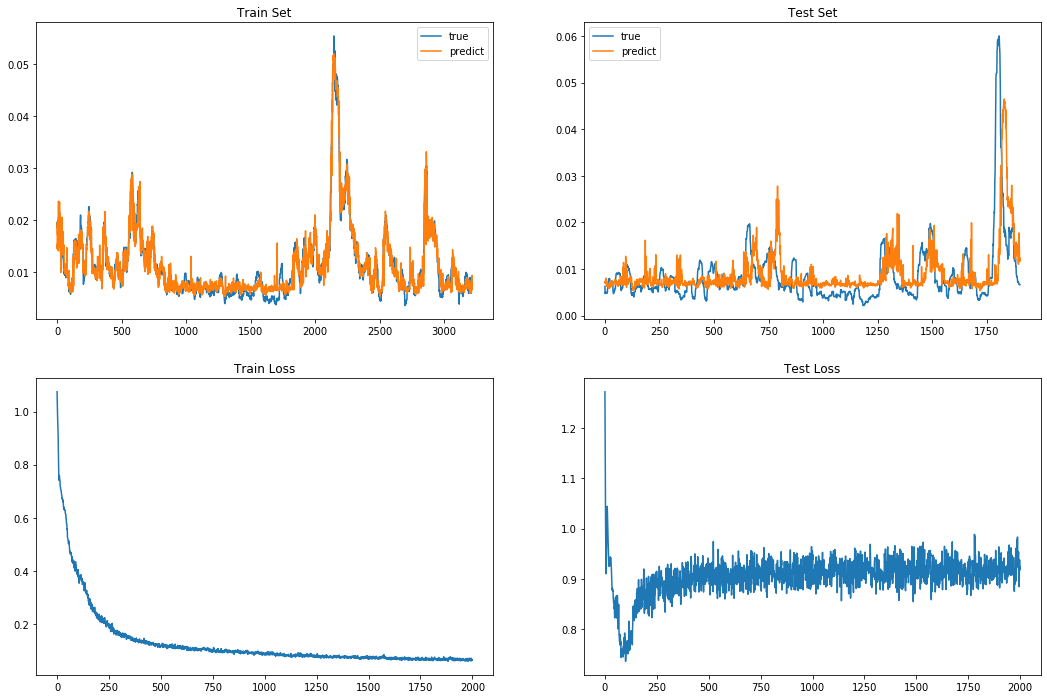

            MAE       MSE      HMAE      HMSE
Train  0.138363  0.032918  0.150752  0.046140
Test   0.374507  0.463973  0.451177  0.352848
Total  0.226133  0.193132  0.262414  0.160137
layer =  3


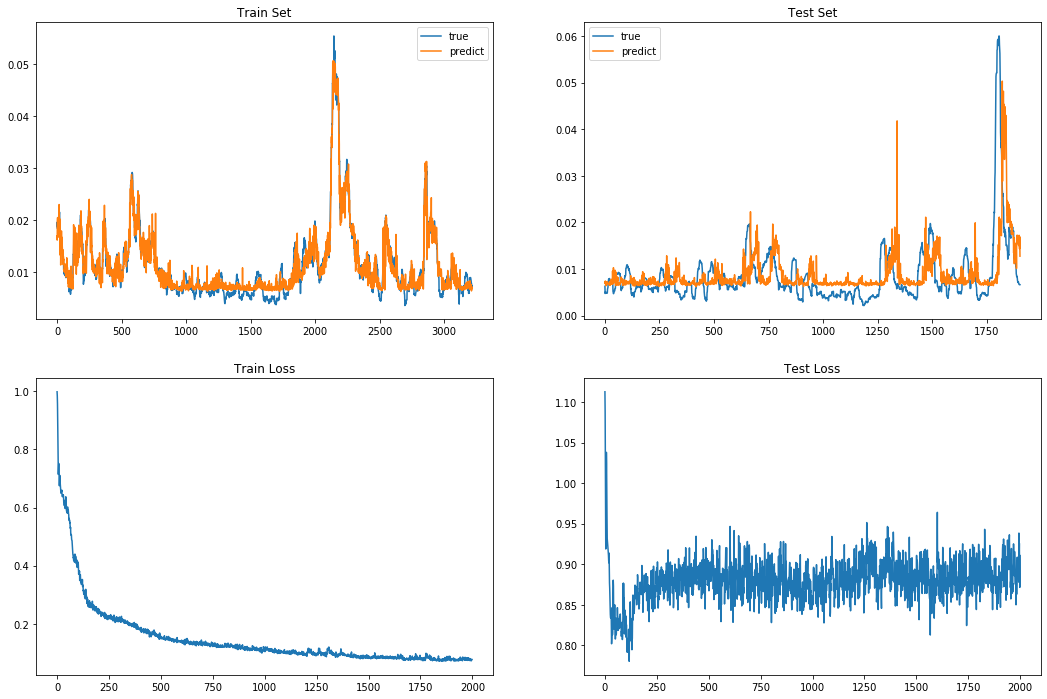

            MAE       MSE      HMAE      HMSE
Train  0.148416  0.038843  0.160837  0.053318
Test   0.373973  0.451411  0.459790  0.368726
Total  0.232251  0.192186  0.271952  0.170549
Rolling Test
layer =  1


C:\Users\UniversityGrass\anaconda3\lib\site-packages\torch\nn\modules\rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


            MAE       MSE      HMAE      HMSE
Train  0.161245  0.046285  0.199776  0.079389
Test   0.326429  0.336183  0.404407  0.288271
Total  0.162367  0.048254  0.201166  0.080808
layer =  2
            MAE       MSE      HMAE      HMSE
Train  0.170706  0.053023  0.209351  0.086083
Test   0.331472  0.368359  0.380755  0.239276
Total  0.171798  0.055165  0.210515  0.087123
layer =  3
            MAE       MSE      HMAE      HMSE
Train  0.194523  0.069718  0.235283  0.106670
Test   0.366373  0.395592  0.481204  0.449729
Total  0.195690  0.071931  0.236954  0.109000


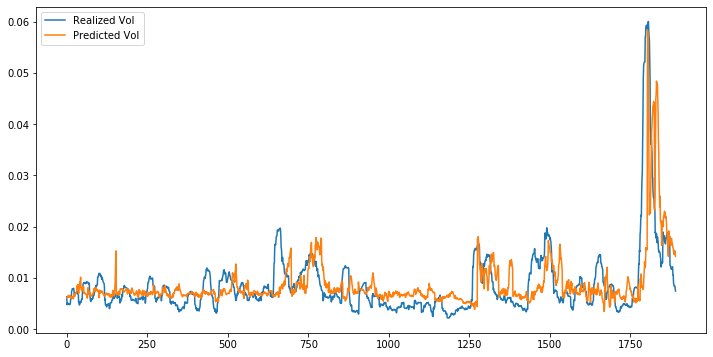

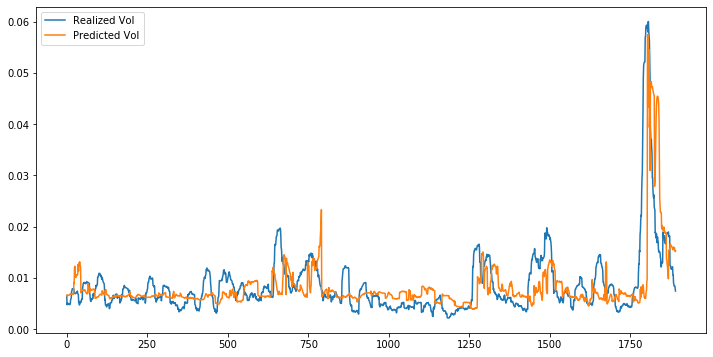

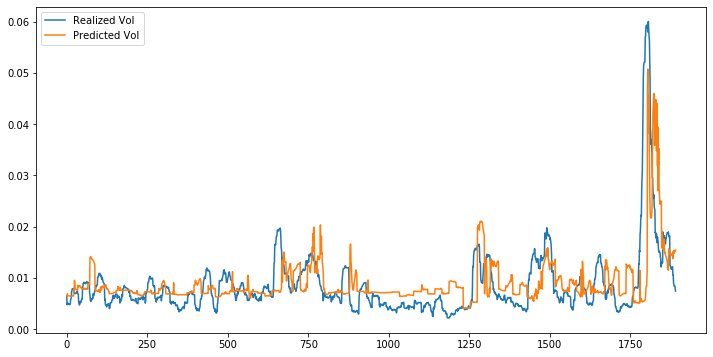

In [12]:
exp_variables = ['garch_cond_vol', 'garch_resid', 'egarch_cond_vol','egarch_std_resid', 'egarch_asymmetric', 'ewma_cond_vol', 'ewma_resid']
plot = False
INPUT_SIZE = len(exp_variables) + 1
HIDDEN_SIZE = 16

print('Split Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    split_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')
print('Rolling Test')
for LAYER_SIZE in range(1, 4):
    print('layer = ', LAYER_SIZE)
    rolling_test(INPUT_SIZE, HIDDEN_SIZE, LAYER_SIZE, exp_variables, index='SPX Index')